# Advanced ML Models to Predict Extreme Precipitation Events

## 1. Enable Synchronous CUDA Error Reporting

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
# Install necessary libraries
!pip install geemap geopandas shap
!pip install pandas numpy matplotlib seaborn
!pip install torch torchvision
!pip install pytorch-lightning pytorch-forecasting

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet

import shap
import geopandas as gpd
import geemap
import ee

## Authenticate GEE

In [ ]:
!pip install earthengine-api google-auth

In [ ]:
!pip install --upgrade earthengine-api

In [ ]:
# import ee
# print(ee.__version__)

In [ ]:
# !earthengine authenticate

In [ ]:
# Authenticate and initialize Earth Engine
# ee.Authenticate()
# ee.Initialize()

In [ ]:
# Verify Earth Engine initialization
# ee.Number(1).getInfo()

In [ ]:
from google.colab import auth
import ee
import os
from google.cloud import storage

# Set your Google Cloud project ID
project_id = 'gee-project-440408'
os.environ['GOOGLE_CLOUD_PROJECT'] = project_id

# Step 1: Authenticate with Google Cloud
auth.authenticate_user()

# Step 2: Authenticate Earth Engine with specific scopes
try:
    ee.Authenticate(scopes=[
        'https://www.googleapis.com/auth/cloud-platform',
        'https://www.googleapis.com/auth/earthengine',
        'https://www.googleapis.com/auth/devstorage.full_control'
    ])
    ee.Initialize(project=project_id)
    print("Earth Engine initialized successfully.")
except Exception as e:
    print("Authentication failed:", e)

Earth Engine initialized successfully.


## Define the Study Area

In [ ]:
# Define the Area of Interest (AOI) for Bangladesh
latitude_min = 20.5
latitude_max = 26.5
longitude_min = 88.0
longitude_max = 92.7

aoi = ee.Geometry.Rectangle([longitude_min, latitude_min, longitude_max, latitude_max])

# Time frame
start_date = '2015-04-01'
end_date = '2019-12-31'

In [ ]:
# Import the country boundaries dataset
countries = ee.FeatureCollection('USDOS/LSIB_SIMPLE/2017')

# Filter for Bangladesh
bangladesh = countries.filter(ee.Filter.eq('country_na', 'Bangladesh')).geometry()

In [ ]:
# Create a map centered on Bangladesh
Map = geemap.Map(center=[23.6850, 90.3563], zoom=7)

# Add Bangladesh boundary to the map
Map.addLayer(bangladesh, {'color': 'red'}, 'Bangladesh Boundary')

# Display the map
Map

Map(center=[23.685, 90.3563], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDat…

## Define the Time Frame and Temporal Sampling

We will focus on Bangladesh and the time period we consider is between April 1, 2015 and December 31, 2019 because this the time range for which we have common data for GPM IMERG Final Run, ERA5 Daily Aggregates, SRTM Digital Elevation Data, MODIS Land Cover Type and SMAP Surface Soil Moisture.

We also focus on monsoon months (June to September).

In [ ]:
# Define the time frame
start_year = 2015
end_year = 2019

# Define monsoon months
monsoon_months = [6, 7, 8, 9]

We also increase spatial scale (20 km) for reducing the volume of the data.

In [ ]:
# resolution in meters
scale = 20000

In [ ]:
# Define AOI covering Bangladesh using latitude and longitude bounds
latitude_min = 20.5
latitude_max = 26.5
longitude_min = 88.0
longitude_max = 92.7

# Create the bounding box geometry
aoi = ee.Geometry.Rectangle([longitude_min, latitude_min, longitude_max, latitude_max])

## Accessing Datasets from GEE with Adjusted Time Frame

1. GPM IMERG Precipitation Data

In [ ]:
# Load GPM IMERG dataset
gpm_dataset = ee.ImageCollection('NASA/GPM_L3/IMERG_V06') \
                    .filterBounds(bangladesh) \
                    .select('precipitationCal')

2. ERA5 Reanalysis Data

In [ ]:
# Load ERA5 Daily dataset
# era5_dataset = ee.ImageCollection('ECMWF/ERA5/DAILY') \
                    #.filterBounds(bangladesh)

                    # Define ERA5 Daily dataset
era5_dataset = ee.ImageCollection('ECMWF/ERA5/DAILY').select([
    'mean_2m_air_temperature',
    'minimum_2m_air_temperature',
    'maximum_2m_air_temperature',
    'dewpoint_2m_temperature',
    'total_precipitation',
    'surface_pressure',
    'mean_sea_level_pressure',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m'
])


3. SRTM Digital Elevation Data

In [ ]:
# Load SRTM Digital Elevation Data
srtm_dataset = ee.Image('USGS/SRTMGL1_003').clip(bangladesh)
# srtm_dataset = ee.ImageCollection('USGS/SRTMGL1_003').first().select('elevation').clip(bangladesh)


4. SMAP Soil Moisture Data

In [ ]:
# Load SMAP Surface Soil Moisture
smap_dataset = ee.ImageCollection('NASA_USDA/HSL/SMAP10KM_soil_moisture') \
                  .filterBounds(bangladesh) \
                  .select('ssm')

5. MODIS Land Cover Data

In [ ]:
# Load MODIS Land Cover for each year
modis_landcover = {}
for year in range(start_year, end_year + 1):
    lc_image = ee.ImageCollection('MODIS/006/MCD12Q1') \
                .filterDate(f'{year}-01-01', f'{year}-12-31') \
                .first() \
                .select('LC_Type1') \
                .clip(bangladesh)
    modis_landcover[str(year)] = lc_image

## Step 3: Define Sample Points

In [ ]:
def create_point_grid(aoi, spacing_deg):
    # Use the provided latitude and longitude bounds directly
    lon_min = longitude_min
    lon_max = longitude_max
    lat_min = latitude_min
    lat_max = latitude_max

    # Create sequences of longitude and latitude
    lon_coords = ee.List.sequence(lon_min, lon_max, spacing_deg)
    lat_coords = ee.List.sequence(lat_min, lat_max, spacing_deg)

    # Print number of coordinates
    print('Number of longitude points:', lon_coords.length().getInfo())
    print('Number of latitude points:', lat_coords.length().getInfo())

    # Create points at the intersections with properties
    def make_points(lat):
        lat = ee.Number(lat)
        return lon_coords.map(lambda lon: ee.Feature(ee.Geometry.Point([lon, lat])) \
                                .set({'longitude': lon, 'latitude': lat}))

    # Generate the grid of points
    points = lat_coords.map(make_points).flatten()

    # Create a FeatureCollection of points
    points_fc = ee.FeatureCollection(points)

    # Filter points to within the AOI
    points_fc = points_fc.filterBounds(aoi)

    return points_fc

In [ ]:
# Create a grid of sample points over the AOI
point_spacing_km = 50

# Convert spacing from kilometers to degrees approximately (1 degree ≈ 111 km)
spacing_deg = point_spacing_km / 111.0

sample_points = create_point_grid(aoi, spacing_deg)

# Check the number of sample points
num_sample_points = sample_points.size().getInfo()
print(f"Number of sample points: {num_sample_points}")

Number of longitude points: 11
Number of latitude points: 14
Number of sample points: 144


In [ ]:
# Import the necessary library
import folium

# Define a method to add Earth Engine layers to folium maps
def add_ee_layer(self, ee_object, vis_params, name):
    map_id_dict = ee_object.getMapId(vis_params)
    folium.TileLayer(
        tiles = map_id_dict['tile_fetcher'].url_format,
        attr = 'Google Earth Engine',
        name = name,
        overlay = True,
        control = True
    ).add_to(self)

# Add the method to folium
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map centered on Bangladesh
map_center = [23.6850, 90.3563]  # Coordinates of Bangladesh
my_map = folium.Map(location=map_center, zoom_start=7)

# Add sample points to the map
my_map.add_ee_layer(sample_points.style(**{'color': 'red'}), {}, 'Sample Points')

# Add layer control and display the map
my_map.add_child(folium.LayerControl())
display(my_map)

In [ ]:
def test_sample_points():
    """Test that sample points have 'longitude' and 'latitude' properties."""
    try:
        first_point = sample_points.first()
        print("\nTesting Sample Points:")
        print("First Point:", first_point)
        print("First Point Properties:", first_point.propertyNames().getInfo())
    except Exception as e:
        print(f"Error during sample points testing: {e}")
        import traceback
        traceback.print_exc()

# Run the test
test_sample_points()


Testing Sample Points:
First Point: ee.Element({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection",
                "arguments": {
                  "features": {
                    "functionInvocationValue": {
                      "functionName": "List.flatten",
                      "arguments": {
                        "list": {
                          "functionInvocationValue": {
                            "functionName": "List.map",
                            "arguments": {
                              "baseAlgorithm": {
                                "functionDefinitionValue": {
                                  "argumentNames": [
                                    "_MAPPING_VAR_1_0"
   

In [ ]:
def test_sample_points():
    """Test that sample points have 'longitude' and 'latitude' properties and retrieve their values."""
    try:
        first_point = sample_points.first()
        print("\nTesting Sample Points:")
        print("First Point:", first_point)
        print("First Point Properties:", first_point.propertyNames().getInfo())

        # Retrieve longitude and latitude values
        longitude = first_point.get('longitude').getInfo()
        latitude = first_point.get('latitude').getInfo()
        print(f"First Point Longitude: {longitude}")
        print(f"First Point Latitude: {latitude}")
    except Exception as e:
        print(f"Error during sample points testing: {e}")
        import traceback
        traceback.print_exc()

# Run the enhanced test
test_sample_points()


Testing Sample Points:
First Point: ee.Element({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection",
                "arguments": {
                  "features": {
                    "functionInvocationValue": {
                      "functionName": "List.flatten",
                      "arguments": {
                        "list": {
                          "functionInvocationValue": {
                            "functionName": "List.map",
                            "arguments": {
                              "baseAlgorithm": {
                                "functionDefinitionValue": {
                                  "argumentNames": [
                                    "_MAPPING_VAR_1_0"
   

In [ ]:
def test_datasets():
    """Test each dataset to ensure they return valid images with expected bands."""
    try:
        # Test GPM
        gpm_first = gpm_dataset.first()
        print("\nTesting GPM Dataset:")
        print("GPM Image:", gpm_first)
        print("GPM Bands:", gpm_first.bandNames().getInfo())

        # Test ERA5
        era5_first = era5_dataset.first()
        print("\nTesting ERA5 Dataset:")
        print("ERA5 Image:", era5_first)
        print("ERA5 Bands:", era5_first.bandNames().getInfo())

        # Test SMAP
        smap_first = smap_dataset.first()
        print("\nTesting SMAP Dataset:")
        print("SMAP Image:", smap_first)
        print("SMAP Bands:", smap_first.bandNames().getInfo())

        # Test MODIS Landcover for 2015
        modis_landcover_2015 = modis_landcover.get('2015')
        print("\nTesting MODIS Landcover 2015:")
        print("Landcover Image:", modis_landcover_2015)
        print("Landcover Bands:", modis_landcover_2015.bandNames().getInfo())

        # Test SRTM
        print("\nTesting SRTM Dataset:")
        print("SRTM Image:", srtm_dataset)
        print("SRTM Bands:", srtm_dataset.bandNames().getInfo())

    except Exception as e:
        print(f"Error during dataset testing: {e}")
        import traceback
        traceback.print_exc()

# Run the test
test_datasets()


Testing GPM Dataset:
GPM Image: ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.select",
                    "arguments": {
                      "bandSelectors": {
                        "constantValue": [
                          "precipitationCal"
                        ]
                      },
                      "input": {
                        "argumentReference": "_MAPPING_VAR_0_0"
                      }
                    }
                  }
                }
              }
            },
            "collecti

## Define Helper Functions for Stratified Sampling and Export

In [ ]:
# Define Helper Functions for Stratified Sampling and Export

num_samples_per_district = 2

# Import the FAO GAUL Level 2 dataset (district level)
districts = ee.FeatureCollection('FAO/GAUL/2015/level2') \
                .filter(ee.Filter.eq('ADM0_NAME', 'Bangladesh'))

def sample_district(district, samples_collection):
    """Perform stratified sampling for each district."""
    # Get district name as an EE object
    district_name = district.get('ADM2_NAME')

    # Filter samples_collection to the current district
    samples_in_district = samples_collection.filterBounds(district.geometry()) \
                                            .randomColumn('random', seed=42) \
                                            .sort('random') \
                                            .limit(num_samples_per_district)

    # Add district name to each sample (server-side)
    samples_in_district = samples_in_district.map(lambda feature: feature.set('district', district_name))

    return samples_in_district

# Creating Export Tasks
# Define your GCS bucket name
gcs_bucket = 'ee-exports-bucket'

## Generate Monsoon Dates

In [ ]:
import datetime

# Generate Monsoon Dates
def generate_monsoon_dates(start_year, end_year, monsoon_months):
    dates = []
    for year in range(start_year, end_year + 1):
        for month in monsoon_months:
            # Handle December edge case
            if month == 12:
                next_month = datetime.date(year + 1, 1, 1)
            else:
                next_month = datetime.date(year, month + 1, 1)
            last_day = (next_month - datetime.timedelta(days=1)).day
            for day in range(1, last_day + 1):
                date_str = f"{year}-{month:02d}-{day:02d}"
                dates.append(date_str)
    return dates

# Define monsoon months (June to September)
monsoon_months = [6, 7, 8, 9]
start_year = 2015
end_year = 2019
dates = generate_monsoon_dates(start_year, end_year, monsoon_months)

## Creating Export Tasks

In [ ]:
# Define your GCS bucket name
gcs_bucket = 'ee-exports-bucket'

In [ ]:
# Function to check if an image is valid (not None and has bands)
def is_valid_image(img):
    return img is not None and img.bandNames().size().getInfo() > 0

# Helper function to create a dataset for a specific date
def prepare_dataset(date):
    ee_date = ee.Date(date)
    year_str = ee_date.format('yyyy').getInfo()
    month = int(date.split('-')[1])

    if month < 6 or month > 9:
        print(f"Skipping date {date} as it's not in monsoon months.")
        return ee.FeatureCollection([])

    print(f"\nProcessing date: {date}")

    try:
        # GPM IMERG Precipitation Data
        gpm_filtered = gpm_dataset.filterDate(date, ee_date.advance(1, 'day'))
        if gpm_filtered.size().getInfo() == 0:
            print("No GPM data for this date")
            return ee.FeatureCollection([])
        gpm_first = gpm_filtered.first()
        print("GPM Image: Valid")
        print(f"GPM Bands: {gpm_first.bandNames().getInfo()}")
        combined_image = ee.Image(gpm_first)

        # ERA5 Data
        era5_filtered = era5_dataset.filterDate(date, ee_date.advance(1, 'day'))
        if era5_filtered.size().getInfo() == 0:
            print("No ERA5 data for this date")
            return ee.FeatureCollection([])
        era5_first = era5_filtered.first()
        print("ERA5 Image: Valid")
        print(f"ERA5 Bands: {era5_first.bandNames().getInfo()}")
        combined_image = combined_image.addBands(era5_first)
        print("Added ERA5 Bands Successfully.")

        # SMAP Data
        smap_filtered = smap_dataset.filterDate(date, ee_date.advance(1, 'day'))
        if smap_filtered.size().getInfo() == 0:
            print("No SMAP data for this date")
            print("Proceeding without SMAP data for this date.")
        else:
            smap_first = smap_filtered.first()
            print("SMAP Image: Valid")
            print(f"SMAP Bands: {smap_first.bandNames().getInfo()}")
            combined_image = combined_image.addBands(smap_first)
            print("Added SMAP Bands Successfully.")

        # MODIS Land Cover
        landcover = modis_landcover.get(year_str)
        if landcover is None:
            print("Landcover Image: None or empty")
            return ee.FeatureCollection([])
        else:
            landcover_band_names = landcover.bandNames().getInfo()
            if len(landcover_band_names) == 0:
                print("Landcover Image has no bands")
                return ee.FeatureCollection([])
            print("Landcover Image: Valid")
            print(f"Landcover Bands: {landcover_band_names}")
            combined_image = combined_image.addBands(landcover)
            print("Added Landcover Bands Successfully.")

        # SRTM Data
        if srtm_dataset is None:
            print("SRTM Image: None or empty")
            return ee.FeatureCollection([])
        else:
            srtm_band_names = srtm_dataset.bandNames().getInfo()
            if len(srtm_band_names) == 0:
                print("SRTM Image has no bands")
                return ee.FeatureCollection([])
            print("SRTM Image: Valid")
            print(f"SRTM Bands: {srtm_band_names}")
            combined_image = combined_image.addBands(srtm_dataset)
            print("Added SRTM Bands Successfully.")

        # Sample points
        sampled_points = combined_image.sampleRegions(
            collection=sample_points,
            properties=['system:index', 'longitude', 'latitude'],  # Ensure properties are included
            scale=scale,
            geometries=True
        )

        # Add date to each feature
        sampled_points = sampled_points.map(lambda feature: feature.set('date', date))

        print(f"Sampled Points for {date}: {sampled_points.size().getInfo()}")

        return sampled_points

    except Exception as e:
        print(f"Error processing date {date}: {e}")
        import traceback
        traceback.print_exc()
        return ee.FeatureCollection([])

In [ ]:
# Split Dates into Batches
batch_size = 1  # Start with batch_size = 1 for testing
date_batches = [dates[i:i + batch_size] for i in range(0, len(dates), batch_size)]

# Define the create_export_task function
def create_export_task(district_samples, batch_index):
    return ee.batch.Export.table.toCloudStorage(
        collection=district_samples,
        description=f'Batch_{batch_index + 1}_District_Stratified_Sample',
        bucket=gcs_bucket,
        fileNamePrefix=f'batch_{batch_index + 1}_district_stratified_sample',
        fileFormat='CSV'
        # selectors=['system:index', 'date', 'longitude', 'latitude', 'district']
    )

## Verify each dataset

In [ ]:
def test_individual_datasets():
    """Test each dataset individually."""
    try:
        # Test GPM
        gpm_first = gpm_dataset.first()
        print("\nTesting GPM Dataset:")
        print("GPM Image:", gpm_first)
        print("GPM Bands:", gpm_first.bandNames().getInfo())

        # Test ERA5
        era5_first = era5_dataset.first()
        print("\nTesting ERA5 Dataset:")
        print("ERA5 Image:", era5_first)
        print("ERA5 Bands:", era5_first.bandNames().getInfo())

        # Test SMAP
        smap_first = smap_dataset.first()
        print("\nTesting SMAP Dataset:")
        print("SMAP Image:", smap_first)
        print("SMAP Bands:", smap_first.bandNames().getInfo())

        # Test MODIS Landcover for 2015
        modis_landcover_2015 = modis_landcover.get('2015')
        print("\nTesting MODIS Landcover 2015:")
        print("Landcover Image:", modis_landcover_2015)
        print("Landcover Bands:", modis_landcover_2015.bandNames().getInfo())

        # Test SRTM
        print("\nTesting SRTM Dataset:")
        print("SRTM Image:", srtm_dataset)
        print("SRTM Bands:", srtm_dataset.bandNames().getInfo())

    except Exception as e:
        print(f"Error during individual dataset testing: {e}")
        import traceback
        traceback.print_exc()

# Run the test
test_individual_datasets()


Testing GPM Dataset:
GPM Image: ee.Image({
  "functionInvocationValue": {
    "functionName": "Collection.first",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.map",
          "arguments": {
            "baseAlgorithm": {
              "functionDefinitionValue": {
                "argumentNames": [
                  "_MAPPING_VAR_0_0"
                ],
                "body": {
                  "functionInvocationValue": {
                    "functionName": "Image.select",
                    "arguments": {
                      "bandSelectors": {
                        "constantValue": [
                          "precipitationCal"
                        ]
                      },
                      "input": {
                        "argumentReference": "_MAPPING_VAR_0_0"
                      }
                    }
                  }
                }
              }
            },
            "collecti

In [ ]:
# Process batches with better error handling
for batch_index, batch in enumerate(date_batches):
    print(f"\nProcessing batch {batch_index + 1}/{len(date_batches)} with dates: {batch}")

    try:
        # Process each date in the batch
        batch_features = []
        for date in batch:
            samples = prepare_dataset(date)
            if samples and samples.size().getInfo() > 0:
                batch_features.append(samples)

        if not batch_features:
            print(f"No valid samples in batch {batch_index + 1}")
            continue

        # Merge all features in the batch
        batch_samples = ee.FeatureCollection(batch_features).flatten()
        batch_samples_size = batch_samples.size().getInfo()

        if batch_samples_size > 0:
            print(f"Total samples in batch {batch_index + 1}: {batch_samples_size}")

            # Stratified sampling for each district
            district_samples = districts.map(lambda district: sample_district(district, batch_samples)).flatten()

            # Create and start export task
            task = create_export_task(district_samples, batch_index)
            task.start()
            print(f"Export task for batch {batch_index + 1} started successfully")

        else:
            print(f"No samples to export for batch {batch_index + 1}")

    except Exception as e:
        print(f"Error processing batch {batch_index + 1}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\nAll export tasks have been initiated. Check their status in the Earth Engine Code Editor.")

Streaming output truncated to the last 5000 lines.
GPM Image: Valid
GPM Bands: ['precipitationCal']
ERA5 Image: Valid
ERA5 Bands: ['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dewpoint_2m_temperature', 'total_precipitation', 'surface_pressure', 'mean_sea_level_pressure', 'u_component_of_wind_10m', 'v_component_of_wind_10m']
Added ERA5 Bands Successfully.
No SMAP data for this date
Proceeding without SMAP data for this date.
Landcover Image: Valid
Landcover Bands: ['LC_Type1']
Added Landcover Bands Successfully.
SRTM Image: Valid
SRTM Bands: ['elevation']
Added SRTM Bands Successfully.
Sampled Points for 2017-09-29: 77
Total samples in batch 365: 77
Export task for batch 365 started successfully

Processing batch 366/610 with dates: ['2017-09-30']

Processing date: 2017-09-30
GPM Image: Valid
GPM Bands: ['precipitationCal']
ERA5 Image: Valid
ERA5 Bands: ['mean_2m_air_temperature', 'minimum_2m_air_temperature', 'maximum_2m_air_temperature', 'dew

## Accessing and Loading the Data from GCS

In [ ]:
# Install necessary libraries
!pip install --upgrade google-cloud-storage
!pip install pandas numpy matplotlib seaborn

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Authenticate with Google Cloud
from google.colab import auth
auth.authenticate_user()

# Set the Google Cloud project ID and bucket name
project_id = 'gee-project-440408'
gcs_bucket = 'ee-exports-bucket'

# Import the Google Cloud Storage client library
from google.cloud import storage

# Initialize the client
client = storage.Client(project=project_id)

# Get the bucket
bucket = client.get_bucket(gcs_bucket)

# List all CSV files in the bucket
blobs = bucket.list_blobs()
csv_files = [blob.name for blob in blobs if blob.name.endswith('.csv')]

print(f"Found {len(csv_files)} CSV files in the bucket.")

# Import StringIO from the io module
from io import StringIO

# Read and concatenate CSV files into a single DataFrame
data_frames = []
for idx, csv_file in enumerate(csv_files):
    print(f"Reading file {idx+1}/{len(csv_files)}: {csv_file}")
    blob = bucket.blob(csv_file)
    # Download the blob as a string and read it into a pandas DataFrame
    content = blob.download_as_text()
    df = pd.read_csv(StringIO(content))
    data_frames.append(df)

# Concatenate all data frames
data = pd.concat(data_frames, ignore_index=True)
print("Data loaded successfully.")

# Display the first few rows of the data
print(data.head())

Found 610 CSV files in the bucket.
Reading file 1/610: batch_100_district_stratified_sample.csv
Reading file 2/610: batch_101_district_stratified_sample.csv
Reading file 3/610: batch_102_district_stratified_sample.csv
Reading file 4/610: batch_103_district_stratified_sample.csv
Reading file 5/610: batch_104_district_stratified_sample.csv
Reading file 6/610: batch_105_district_stratified_sample.csv
Reading file 7/610: batch_106_district_stratified_sample.csv
Reading file 8/610: batch_107_district_stratified_sample.csv
Reading file 9/610: batch_108_district_stratified_sample.csv
Reading file 10/610: batch_109_district_stratified_sample.csv
Reading file 11/610: batch_10_district_stratified_sample.csv
Reading file 12/610: batch_110_district_stratified_sample.csv
Reading file 13/610: batch_111_district_stratified_sample.csv
Reading file 14/610: batch_112_district_stratified_sample.csv
Reading file 15/610: batch_113_district_stratified_sample.csv
Reading file 16/610: batch_114_district_strat

In [ ]:
data.head()

,system:index,LC_Type1,date,dewpoint_2m_temperature,district,elevation,latitude,longitude,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,precipitationCal,random,ssm,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,.geo
0,0001000000000000152c_0_60_0,14,2015-09-08,300.00653,Barisal,7,22.752252,90.252252,307.16632,303.03452,100561.15,300.62338,0.000000,0.880792,25.352697,100500.01,0.004516,0.253550,1.892216,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,0001000000000000152d_0_61_0,17,2015-09-08,300.06710,Bhola,3,22.752252,90.702703,306.02423,303.06302,100571.40,300.92047,0.339275,0.361635,25.400000,100502.22,0.002448,0.226889,2.059613,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,0001000000000000152f_0_49_0,12,2015-09-08,300.01890,Patuakhali,6,22.301802,90.252252,306.85144,303.08670,100569.82,300.58423,0.400865,0.068864,25.391220,100505.99,0.002340,0.284822,1.861465,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,0001000000000000152f_0_50_0,12,2015-09-08,300.10635,Patuakhali,6,22.301802,90.702703,305.82678,303.07610,100573.69,300.90802,0.399396,0.128876,25.287668,100516.22,0.001723,0.253257,1.913195,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,00010000000000001531_0_43_0,8,2015-09-08,297.90830,Bandarban,230,21.851351,92.504505,303.39853,300.21677,100672.28,297.58673,0.000000,0.089326,25.319649,99105.94,0.007292,-0.293293,1.056234,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


In [ ]:
data.columns.tolist()

['system:index',
 'LC_Type1',
 'date',
 'dewpoint_2m_temperature',
 'district',
 'elevation',
 'latitude',
 'longitude',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'precipitationCal',
 'random',
 'ssm',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 '.geo']

## Understanding data

In [ ]:
# Check the columns in the data
print("Data columns:", data.columns.tolist())

# Display sample data
print("Sample data:")
print(data.head())

# Get basic statistics
print("Data description:")
print(data.describe())

# Check for missing values
print("Missing values:")
print(data.isnull().sum())

# Check data types
print("Data types:")
print(data.dtypes)

Data columns: ['system:index', 'LC_Type1', 'date', 'dewpoint_2m_temperature', 'district', 'elevation', 'latitude', 'longitude', 'maximum_2m_air_temperature', 'mean_2m_air_temperature', 'mean_sea_level_pressure', 'minimum_2m_air_temperature', 'precipitationCal', 'random', 'ssm', 'surface_pressure', 'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m', '.geo']
Sample data:
                  system:index  LC_Type1        date  dewpoint_2m_temperature  \
0  0001000000000000152c_0_60_0        14  2015-09-08                300.00653   
1  0001000000000000152d_0_61_0        17  2015-09-08                300.06710   
2  0001000000000000152f_0_49_0        12  2015-09-08                300.01890   
3  0001000000000000152f_0_50_0        12  2015-09-08                300.10635   
4  00010000000000001531_0_43_0         8  2015-09-08                297.90830   

     district  elevation   latitude  longitude  maximum_2m_air_temperature  \
0     Barisal          7  22.752252  9

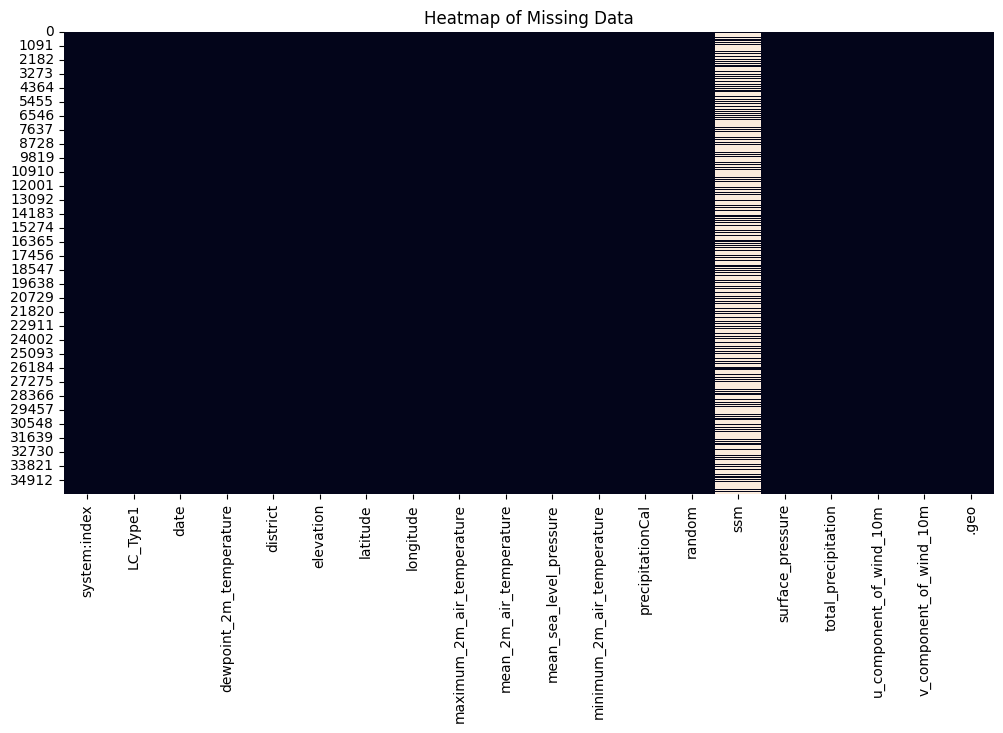

In [ ]:
# Check for patterns in missing data
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize missing data
plt.figure(figsize=(12,6))
sns.heatmap(data.isnull(), cbar=False)
plt.title('Heatmap of Missing Data')
plt.show()

In [ ]:
!pip install geemap geopandas shap
!pip install pandas numpy matplotlib seaborn

In [ ]:
# Install necessary libraries
!pip install geemap geopandas shap
!pip install pandas numpy matplotlib seaborn
!pip install torch torchvision
!pip install pytorch-lightning pytorch-forecasting

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet, QuantileLoss
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


## Check GPU Availability

In [ ]:
# Check if GPU is available
print(f"Is GPU available? {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

Is GPU available? True
Number of GPUs: 1


## We'll interpolate missing 'ssm' values per location over time.

In [ ]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Sort data by location and date
data.sort_values(['longitude', 'latitude', 'date'], inplace=True)

# Interpolate 'ssm' per location using groupby().transform()
data['ssm_interpolated'] = data.groupby(['longitude', 'latitude'])['ssm'].transform(
    lambda group: group.interpolate(method='linear')
)

# Forward-fill and backward-fill remaining NaN values per location
data['ssm_interpolated'] = data.groupby(['longitude', 'latitude'])['ssm_interpolated'].transform(
    lambda group: group.fillna(method='ffill').fillna(method='bfill')
)

<ipython-input-7-754737e78ac1>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda group: group.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Drop the 'ssm' column
data.drop(columns=['ssm'], inplace=True)

## Fill missing 'LC_Type1' values per location using the mode (most frequent value)

In [ ]:
# Convert 'LC_Type1' to integer (handling missing values)
data['LC_Type1'] = data['LC_Type1'].astype('Int64')

# Define a function to fill missing 'LC_Type1' values per group
def fill_lc_type(group):
    # Fill with mode
    if not group.mode().empty:
        group = group.fillna(group.mode().iloc[0])
    else:
        group = group
    # Then forward-fill and backward-fill
    group = group.ffill().bfill()
    return group

# Apply the function using groupby().transform()
data['LC_Type1_filled'] = data.groupby(['longitude', 'latitude'])['LC_Type1'].transform(fill_lc_type)

"""
# Map the numerical codes to category names
lc_type_mapping = {
    0: 'Water',
    1: 'Evergreen Needleleaf Forest',
    2: 'Evergreen Broadleaf Forest',
    3: 'Deciduous Needleleaf Forest',
    4: 'Deciduous Broadleaf Forest',
    5: 'Mixed Forest',
    6: 'Closed Shrublands',
    7: 'Open Shrublands',
    8: 'Woody Savannas',
    9: 'Savannas',
    10: 'Grasslands',
    11: 'Permanent Wetlands',
    12: 'Croplands',
    13: 'Urban and Built-up',
    14: 'Cropland/Natural Vegetation Mosaic',
    15: 'Snow and Ice',
    16: 'Barren or Sparsely Vegetated',
    17: 'Unclassified',
    18: 'Fill Value'
}

data['LC_Type1_filled'] = data['LC_Type1_filled'].map(lc_type_mapping)
"""

"\n# Map the numerical codes to category names\nlc_type_mapping = {\n    0: 'Water',\n    1: 'Evergreen Needleleaf Forest',\n    2: 'Evergreen Broadleaf Forest',\n    3: 'Deciduous Needleleaf Forest',\n    4: 'Deciduous Broadleaf Forest',\n    5: 'Mixed Forest',\n    6: 'Closed Shrublands',\n    7: 'Open Shrublands',\n    8: 'Woody Savannas',\n    9: 'Savannas',\n    10: 'Grasslands',\n    11: 'Permanent Wetlands',\n    12: 'Croplands',\n    13: 'Urban and Built-up',\n    14: 'Cropland/Natural Vegetation Mosaic',\n    15: 'Snow and Ice',\n    16: 'Barren or Sparsely Vegetated',\n    17: 'Unclassified',\n    18: 'Fill Value'\n}\n\ndata['LC_Type1_filled'] = data['LC_Type1_filled'].map(lc_type_mapping)\n"

In [ ]:
data.head()

,system:index,LC_Type1,date,dewpoint_2m_temperature,district,elevation,latitude,longitude,maximum_2m_air_temperature,mean_2m_air_temperature,...,minimum_2m_air_temperature,precipitationCal,random,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,.geo,ssm_interpolated,LC_Type1_filled
13086,00010000000000001561_0_100_0,12,2015-06-02,298.91180,Rajshahi,31,24.554054,88.45045,309.35065,303.96027,...,300.64175,0.0,0.044302,100055.460,0.001884,0.008097,2.417150,"{""geodesic"":false,""type"":""Point"",""coordinates""...",4.487515,12
26185,00010000000000001561_0_100_0,12,2015-06-04,298.81934,Rajshahi,31,24.554054,88.45045,309.47467,305.51280,...,302.13630,0.0,0.620968,100172.150,0.000043,-0.426576,2.230481,"{""geodesic"":false,""type"":""Point"",""coordinates""...",4.487515,12
32734,00010000000000001561_0_100_0,12,2015-06-05,298.73477,Rajshahi,31,24.554054,88.45045,309.92650,305.83435,...,302.18915,0.0,0.735431,100001.040,0.000072,0.472010,2.692325,"{""geodesic"":false,""type"":""Point"",""coordinates""...",4.141318,12
34031,00010000000000001561_0_100_0,12,2015-06-06,299.13596,Rajshahi,31,24.554054,88.45045,310.72037,306.17813,...,302.28506,0.0,0.271971,99820.210,0.000242,0.031109,3.343739,"{""geodesic"":false,""type"":""Point"",""coordinates""...",3.795120,12
34680,00010000000000001561_0_100_0,12,2015-06-07,299.33044,Rajshahi,31,24.554054,88.45045,310.93842,305.72780,...,302.14038,0.0,0.113032,99797.445,0.000980,0.260482,3.873744,"{""geodesic"":false,""type"":""Point"",""coordinates""...",3.448922,12


In [ ]:
# Drop the 'LC_Type1' column
data.drop(columns=['LC_Type1'], inplace=True)

## Dealing with missing values in 'elevation' column

Elevation is constant per location. We'll fill missing 'elevation' values per location using the available data.

In [ ]:
# Fill missing 'elevation' values per location
data['elevation_filled'] = data.groupby(['longitude', 'latitude'])['elevation'].transform(
    lambda group: group.fillna(method='ffill').fillna(method='bfill')
)

<ipython-input-12-4cb9d669583b>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lambda group: group.fillna(method='ffill').fillna(method='bfill')


In [ ]:
# Drop the 'elevation' column
data.drop(columns=['elevation'], inplace=True)

In [ ]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

Missing values:
system:index                  0
date                          0
dewpoint_2m_temperature       0
district                      0
latitude                      0
longitude                     0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
precipitationCal              0
random                        0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
.geo                          0
ssm_interpolated              0
LC_Type1_filled               0
elevation_filled              0
dtype: int64


## Check the missing values

In [ ]:
# Identify rows with missing values
missing_data = data[data.isnull().any(axis=1)]

print(f"Number of rows with missing values: {len(missing_data)}")

Number of rows with missing values: 0


## K nearest neighbor imputation for other columns with missing values

In [ ]:
# List of variables to impute
knn_impute_vars = [
    'dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature',
    'mean_sea_level_pressure', 'minimum_2m_air_temperature', 'surface_pressure',
    'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m'
]

# Initialize KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Impute missing values
data[knn_impute_vars] = knn_imputer.fit_transform(data[knn_impute_vars])

## Drop the 'random' Column

In [ ]:
# Drop 'random' column if it exists
if 'random' in data.columns:
    data = data.drop(columns=['random'])

In [ ]:
# Check for remaining missing values
print("Remaining missing values:")
print(data.isnull().sum())

Remaining missing values:
system:index                  0
date                          0
dewpoint_2m_temperature       0
district                      0
latitude                      0
longitude                     0
maximum_2m_air_temperature    0
mean_2m_air_temperature       0
mean_sea_level_pressure       0
minimum_2m_air_temperature    0
precipitationCal              0
surface_pressure              0
total_precipitation           0
u_component_of_wind_10m       0
v_component_of_wind_10m       0
.geo                          0
ssm_interpolated              0
LC_Type1_filled               0
elevation_filled              0
dtype: int64


## Dealing with missing values in precipitationCal column

In [ ]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Sort data by location and date
data.sort_values(['longitude', 'latitude', 'date'], inplace=True)

# Define the interpolation function
def interpolate_group(group):
    # Set 'date' as the index
    group = group.set_index('date')
    # Perform time-based interpolation
    group['precipitationCal_interpolated'] = group['precipitationCal'].interpolate(method='time')
    # Reset the index
    group = group.reset_index()
    return group

# Apply the interpolation function to each group
data = data.groupby(['longitude', 'latitude']).apply(interpolate_group)

# Reset index to flatten the DataFrame
data.reset_index(drop=True, inplace=True)

# Handle any remaining NaNs with forward-fill and backward-fill
data['precipitationCal_interpolated'] = data.groupby(['longitude', 'latitude'])['precipitationCal_interpolated'].transform(
    lambda group: group.ffill().bfill()
)

# Verify that there are no remaining missing values
missing_values = data['precipitationCal_interpolated'].isnull().sum()
print(f"Number of missing values in 'precipitationCal_interpolated': {missing_values}")

Number of missing values in 'precipitationCal_interpolated': 0


<ipython-input-19-2cab73556086>:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby(['longitude', 'latitude']).apply(interpolate_group)


In [ ]:
# Check for remaining missing values
print("Remaining missing values:")
print(data.isnull().sum())

Remaining missing values:
date                             0
system:index                     0
dewpoint_2m_temperature          0
district                         0
latitude                         0
longitude                        0
maximum_2m_air_temperature       0
mean_2m_air_temperature          0
mean_sea_level_pressure          0
minimum_2m_air_temperature       0
precipitationCal                 0
surface_pressure                 0
total_precipitation              0
u_component_of_wind_10m          0
v_component_of_wind_10m          0
.geo                             0
ssm_interpolated                 0
LC_Type1_filled                  0
elevation_filled                 0
precipitationCal_interpolated    0
dtype: int64


## Drop the remaining two columns with missing values that we don't need any more

In [ ]:
# Drop the 'precipitationCal' and '.geo' column
data.drop(columns=['precipitationCal'], inplace=True)
data.drop(columns=['.geo'], inplace=True)

In [ ]:
# Check for remaining missing values
print("Remaining missing values:")
print(data.isnull().sum())

Remaining missing values:
date                             0
system:index                     0
dewpoint_2m_temperature          0
district                         0
latitude                         0
longitude                        0
maximum_2m_air_temperature       0
mean_2m_air_temperature          0
mean_sea_level_pressure          0
minimum_2m_air_temperature       0
surface_pressure                 0
total_precipitation              0
u_component_of_wind_10m          0
v_component_of_wind_10m          0
ssm_interpolated                 0
LC_Type1_filled                  0
elevation_filled                 0
precipitationCal_interpolated    0
dtype: int64


In [ ]:
data.drop(columns=['system:index'], inplace=True)

In [ ]:
# Check for remaining missing values
print("Remaining missing values:")
print(data.isnull().sum())

Remaining missing values:
date                             0
dewpoint_2m_temperature          0
district                         0
latitude                         0
longitude                        0
maximum_2m_air_temperature       0
mean_2m_air_temperature          0
mean_sea_level_pressure          0
minimum_2m_air_temperature       0
surface_pressure                 0
total_precipitation              0
u_component_of_wind_10m          0
v_component_of_wind_10m          0
ssm_interpolated                 0
LC_Type1_filled                  0
elevation_filled                 0
precipitationCal_interpolated    0
dtype: int64


# Feature Engineering

Extract Temporal Features

In [ ]:
# Ensure 'date' is in datetime format
data['date'] = pd.to_datetime(data['date'])

# Extract temporal features from 'date'
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['dayofweek'] = data['date'].dt.dayofweek

### Lag Features for Precipitation

In [ ]:
# Sort data by location and date
data.sort_values(['longitude', 'latitude', 'date'], inplace=True)

# Create lag features using 'precipitationCal_interpolated'
data['precipitationCal_lag1'] = data.groupby(['longitude', 'latitude'])['precipitationCal_interpolated'].shift(1)
data['precipitationCal_lag7'] = data.groupby(['longitude', 'latitude'])['precipitationCal_interpolated'].shift(7)

# Fill NaN values in lag features with zero
data['precipitationCal_lag1'] = data['precipitationCal_lag1'].fillna(0)
data['precipitationCal_lag7'] = data['precipitationCal_lag7'].fillna(0)

## Step 2: Target Variable Creation

Define the target variable for extreme precipitation events.

In [ ]:
# Define threshold for extreme precipitation (e.g., 95th percentile)
threshold = data['precipitationCal_interpolated'].quantile(0.80)
print(f"Extreme precipitation threshold: {threshold}")

# Create binary target variable
data['extreme_precipitation'] = (data['precipitationCal_interpolated'] >= threshold).astype(int)

Extreme precipitation threshold: 0.5082170400000002


In [ ]:
data['precipitationCal_interpolated'].unique()

array([0.        , 0.0696198 , 0.22932771, ..., 0.3892544 , 1.2066659 ,
       0.31494546])

## Data Encoding

Encode categorical variables.

In [ ]:
# Update categorical columns
categorical_columns = ['LC_Type1_filled', 'district']

# Convert categorical columns to 'category' dtype and then to integer codes
for col in categorical_columns:
    data[col] = data[col].astype('category').cat.codes
    data[col] = data[col].astype('int')

## Normalization and Scaling

In [ ]:
# List of numerical columns (excluding 'latitude' and 'longitude')
numerical_columns = [
    'dewpoint_2m_temperature', 'maximum_2m_air_temperature', 'mean_2m_air_temperature',
    'mean_sea_level_pressure', 'minimum_2m_air_temperature', 'surface_pressure',
    'total_precipitation', 'u_component_of_wind_10m', 'v_component_of_wind_10m',
    'ssm_interpolated', 'elevation_filled', 'precipitationCal_lag1', 'precipitationCal_lag7'
]

### Apply StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler
scaler = StandardScaler()

# Apply StandardScaler to numerical columns
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

## Data Splitting

We will not drop 'latitude' and 'longitude' as they are needed for grouping.

In [ ]:
# Ensure 'date' is sorted
data = data.sort_values('date')

# Create 'time_idx' for time series indexing
data['time_idx'] = (data['date'] - data['date'].min()).dt.days

## Model Development and Analysis


### Define the real features and categorical features

In [ ]:
# Static categorical variables
static_categoricals = ['LC_Type1_filled', 'district']

# Time-varying known real variables (exclude 'latitude' and 'longitude')
time_varying_known_reals = ['time_idx', 'month', 'day', 'dayofweek']

# Time-varying unknown real variables
time_varying_unknown_reals = numerical_columns

In [ ]:
data.head()

,date,dewpoint_2m_temperature,district,latitude,longitude,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,...,elevation_filled,precipitationCal_interpolated,year,month,day,dayofweek,precipitationCal_lag1,precipitationCal_lag7,extreme_precipitation,time_idx
22159,2015-06-01,0.278130,6,23.202703,90.702703,1.029625,1.242027,0.401391,0.895034,0.491407,...,-0.461742,0.000000,2015,6,1,0,-0.303772,-0.301551,0,0
16470,2015-06-01,-2.098234,23,25.905405,89.801802,-1.320420,-1.943701,0.222367,-2.545018,0.271173,...,0.028355,1.404055,2015,6,1,0,-0.303772,-0.301551,1,0
34562,2015-06-01,-0.450917,1,21.400901,92.504505,1.424438,1.006483,1.064640,0.231485,-0.095736,...,4.096156,0.000000,2015,6,1,0,-0.303772,-0.301551,0,0
15250,2015-06-01,-0.335059,17,25.004505,89.801802,0.519312,-0.082324,0.112679,-1.076426,0.212183,...,-0.216694,0.000000,2015,6,1,0,-0.303772,-0.301551,0,0
34959,2015-06-01,-1.339967,1,21.851351,92.504505,1.201635,0.998662,1.056779,0.194623,-0.383901,...,4.929320,0.000000,2015,6,1,0,-0.303772,-0.301551,0,0


### Create a Unique Group Identifier

In [ ]:
# Create a unique identifier for each location
data['location_id'] = data.groupby(['longitude', 'latitude']).ngroup().astype('int')

In [ ]:
df = data.copy()

In [ ]:
df.columns.tolist()

['date',
 'dewpoint_2m_temperature',
 'district',
 'latitude',
 'longitude',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'ssm_interpolated',
 'LC_Type1_filled',
 'elevation_filled',
 'precipitationCal_interpolated',
 'year',
 'month',
 'day',
 'dayofweek',
 'precipitationCal_lag1',
 'precipitationCal_lag7',
 'extreme_precipitation',
 'time_idx',
 'location_id']

In [ ]:
# Check data types
print("Data types:")
print(df.dtypes)

Data types:
date                             datetime64[ns]
dewpoint_2m_temperature                 float64
district                                  int64
latitude                                float64
longitude                               float64
maximum_2m_air_temperature              float64
mean_2m_air_temperature                 float64
mean_sea_level_pressure                 float64
minimum_2m_air_temperature              float64
surface_pressure                        float64
total_precipitation                     float64
u_component_of_wind_10m                 float64
v_component_of_wind_10m                 float64
ssm_interpolated                        float64
LC_Type1_filled                           int64
elevation_filled                        float64
precipitationCal_interpolated           float64
year                                      int32
month                                     int32
day                                       int32
dayofweek                   

### Drop 'longitude' and 'latitude' from Features

In [ ]:
# Drop 'longitude' and 'latitude' from data
data = data.drop(columns=['longitude', 'latitude'])

### Create the Training TimeSeriesDataSet

In [ ]:
# Split data into training and test sets based on date
train_data = data[data['date'] < '2019-01-01']
test_data = data[data['date'] >= '2019-01-01']

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Drop unnecessary columns
columns_to_drop = ['date', 'LC_Type1', 'elevation', 'ssm', 'precipitationCal_interpolated']
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

Training data shape: (28792, 24)
Test data shape: (7198, 24)


In [ ]:
train_data.columns.tolist()

['dewpoint_2m_temperature',
 'district',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'ssm_interpolated',
 'LC_Type1_filled',
 'elevation_filled',
 'year',
 'month',
 'day',
 'dayofweek',
 'precipitationCal_lag1',
 'precipitationCal_lag7',
 'extreme_precipitation',
 'time_idx',
 'location_id']

## Create Training Dataset

In [ ]:
from pytorch_forecasting import TimeSeriesDataSet

# Define the maximum prediction length and encoder length
max_encoder_length = 10  # Number of days to look back
max_prediction_length = 1  # Predicting the next day

# Define the training cutoff
N = 5
training_cutoff = train_data['time_idx'].max() - max_prediction_length - N


# Convert 'LC_Type1_filled' and 'district' in train_data to strings, then to 'category' dtype
train_data['LC_Type1_filled'] = train_data['LC_Type1_filled'].astype(str).astype('category')
train_data['district'] = train_data['district'].astype(str).astype('category')

# Update static_categoricals to include both 'LC_Type1_filled' and 'district'
static_categoricals = ['LC_Type1_filled', 'district']

# Define the TimeSeriesDataSet
training = TimeSeriesDataSet(
    train_data[train_data['time_idx'] <= training_cutoff],
    time_idx='time_idx',
    target='extreme_precipitation',
    group_ids=['location_id'],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    static_categoricals=static_categoricals,  # Include both 'LC_Type1_filled' and 'district'
    target_normalizer=None,  # For classification
    add_relative_time_idx=True,
    add_encoder_length=True,
    allow_missing_timesteps=True,  # Allow gaps in time steps
)

In [ ]:
data.columns.tolist()

['date',
 'dewpoint_2m_temperature',
 'district',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'ssm_interpolated',
 'LC_Type1_filled',
 'elevation_filled',
 'precipitationCal_interpolated',
 'year',
 'month',
 'day',
 'dayofweek',
 'precipitationCal_lag1',
 'precipitationCal_lag7',
 'extreme_precipitation',
 'time_idx',
 'location_id']

## Validation Datasets

In [ ]:
 # Create validation dataset
validation = TimeSeriesDataSet.from_dataset(
    training,
    train_data,
    min_prediction_idx=training_cutoff + 1
)

### Determine the Number of Groups:

Check the number of unique location_ids in the dataset:

In [ ]:
"""
# Number of unique groups in the training data
num_groups_train = train_data['location_id'].nunique()
print(f"Number of unique groups in training data: {num_groups_train}")

# Number of unique groups in the entire dataset
num_groups_total = data['location_id'].nunique()
print(f"Total number of unique groups in the dataset: {num_groups_total}")
"""

'\n# Number of unique groups in the training data\nnum_groups_train = train_data[\'location_id\'].nunique()\nprint(f"Number of unique groups in training data: {num_groups_train}")\n\n# Number of unique groups in the entire dataset\nnum_groups_total = data[\'location_id\'].nunique()\nprint(f"Total number of unique groups in the dataset: {num_groups_total}")\n'

## Create DataLoaders

In [ ]:
"""
import os

# Determine the number of workers based on the environment
num_workers = os.cpu_count()

# Create DataLoaders
batch_size = 64  # Adjust based on your GPU memory capacity
train_dataloader = training.to_dataloader(
    train=True,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)
val_dataloader = validation.to_dataloader(
    train=False,
    batch_size=batch_size * 10,
    num_workers=num_workers,
    pin_memory=True
)
"""

'\nimport os\n\n# Determine the number of workers based on the environment\nnum_workers = os.cpu_count()\n\n# Create DataLoaders\nbatch_size = 64  # Adjust based on your GPU memory capacity\ntrain_dataloader = training.to_dataloader(\n    train=True,\n    batch_size=batch_size,\n    num_workers=num_workers,\n    pin_memory=True\n)\nval_dataloader = validation.to_dataloader(\n    train=False,\n    batch_size=batch_size * 10,\n    num_workers=num_workers,\n    pin_memory=True\n)\n'

## Define and Train the Model

In [ ]:
from pytorch_forecasting.models import TemporalFusionTransformer
from pytorch_forecasting.metrics import CrossEntropy  # For binary classification
# from pytorch_forecasting.metrics import BinaryCrossEntropy  # For binary classification
import pytorch_lightning as pl
import torch
from lightning_fabric.utilities.apply_func import move_data_to_device
# from pytorch_lightning.utilities.apply_func import move_data_to_device

In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_forecasting.metrics import CrossEntropy
from pytorch_forecasting.models import TemporalFusionTransformer
from lightning_fabric.utilities.apply_func import move_data_to_device

# Step 1: Define Callbacks
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=False,
    mode="min",
)

lr_logger = LearningRateMonitor(logging_interval='epoch')

# Step 2: Define the create_mask Function
def create_mask(max_length, lengths):
    device = lengths.device
    range_tensor = torch.arange(max_length, device=device).unsqueeze(0)
    mask = range_tensor >= lengths.unsqueeze(1)
    return mask

# Step 3: Create Custom Temporal Fusion Transformer Class
class CustomTemporalFusionTransformer(TemporalFusionTransformer):
    def get_attention_mask(self, encoder_lengths, decoder_lengths):
        device = encoder_lengths.device

        encoder_length = encoder_lengths.max()
        decoder_length = decoder_lengths.max()

        # Create masks
        encoder_mask = create_mask(encoder_length, encoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        decoder_mask = create_mask(decoder_length, decoder_lengths).unsqueeze(-1)

        # Combine masks
        mask = torch.cat((encoder_mask.to(device), decoder_mask.to(device)), dim=2)

        return mask

# Step 4: Define the Temporal Fusion Transformer model
tft_model = CustomTemporalFusionTransformer.from_dataset(
    training,  # Your TimeSeriesDataSet instance
    learning_rate=0.001,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=CrossEntropy(),
    output_size=2,
    logging_metrics=[],
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# Step 5: Prepare Data Loaders
train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=64, num_workers=4)

# Step 6: Create a Recursive Function to Move Data to Device
def recursive_to_device(data, device):
    if isinstance(data, torch.Tensor):
        return data.to(device)
    elif isinstance(data, dict):
        return {k: recursive_to_device(v, device) for k, v in data.items()}
    elif isinstance(data, list):
        return [recursive_to_device(v, device) for v in data]
    elif isinstance(data, tuple):
        return tuple(recursive_to_device(v, device) for v in data)
    else:
        return data

# Step 7: Create a Custom LightningModule Wrapper
class TemporalFusionTransformerLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = model.loss
        self.save_hyperparameters(ignore=['model', 'loss'])

    def forward(self, x):
        output = self.model(x)
        return output['prediction']  # Return only the prediction tensor

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()  # Extract target tensor and cast to long
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()  # Extract target tensor and cast to long
        y_pred = self(x)
        loss = self.loss(y_pred, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        # During prediction, batch might only contain x
        if isinstance(batch, tuple) or isinstance(batch, list):
            x = batch[0]
        else:
            x = batch
        x = recursive_to_device(x, self.device)
        y_pred = self(x)
        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.model.hparams.learning_rate
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=self.model.hparams.reduce_on_plateau_patience,
            factor=0.5,
            verbose=False,
        )
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1,
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

# Step 8: Instantiate the LightningModule
tft_lightning_module = TemporalFusionTransformerLightningModule(tft_model)

# Step 9: Define the PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    callbacks=[lr_logger, early_stop_callback],
    gradient_clip_val=0.1,
    precision=32,  # Use full 32-bit precision
)

# Step 10: Train the Model
trainer.fit(
    tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of dependencies in default parameter settings. Users who wish to ensure their code continues using 'ranger' as optimizer should ensure that pytorch_optimizer is installed, and set the optimizer parameter explicitly to 'ranger'.
  super().__init__(loss=loss, logging_metrics=logging_me

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 64. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/data.py:78: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 11. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Get Predictions from the Trained Model

Use the trained TFT model to generate predictions on the validation dataset.

In [ ]:
# Use the trainer's predict method
predictions = trainer.predict(tft_lightning_module, dataloaders=val_dataloader)

# Concatenate predictions from all batches
import torch
predictions = torch.cat(predictions, dim=0).cpu().numpy()

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

## Extract Actual Targets

In [ ]:
# Extract actual targets from the validation dataloader
actuals = []
for batch in val_dataloader:
    y = batch[1]
    y = y[0]  # Extract the target tensor
    actuals.append(y)
actuals = torch.cat(actuals, dim=0).cpu().numpy()

## Compute Probabilities and Predicted Labels

In [ ]:
import numpy as np

# If predictions are logits, convert to probabilities
# Assuming predictions are logits for each class
probabilities = np.exp(predictions) / np.exp(predictions).sum(axis=-1, keepdims=True)

# Predicted class labels
y_pred = probabilities.argmax(axis=-1)

# Actual class labels
y_true = actuals

## Compute Evaluation Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary')  # Adjust 'average' as needed
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print('Validation Metrics:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Validation Metrics:
Accuracy: 0.9637
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Troubleshooting

### Check Class Distribution in Actual Labels

In [ ]:
import numpy as np

# Count of actual classes
unique, counts = np.unique(y_true, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Actual class distribution:", class_distribution)

Actual class distribution: {0.0: 319, 1.0: 12}


## Check Class Distribution in Predicted Labels

In [ ]:
# Count of predicted classes
unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
predicted_distribution = dict(zip(unique_pred, counts_pred))
print("Predicted class distribution:", predicted_distribution)

Predicted class distribution: {0: 331}


## Examine the Predictions

In [ ]:
# Print a sample of probabilities
print("Sample probabilities:\n", probabilities[:5])

Sample probabilities:
 [[[0.9875815  0.01241848]]

 [[0.9856313  0.01436875]]

 [[0.9911612  0.00883877]]

 [[0.9904911  0.00950887]]

 [[0.9909176  0.00908239]]]


## **We can see that our model has not been able to detect any positive case.**

So, I will use weighted loss function to see if it improves the model in detecting the positive case. The plan is to assign higher weights to the minority class to penalize the model more when it misclassifies those instances.

In [ ]:
import torch

# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


## Option A: Use Weighted Cross-Entropy Loss

### 1. Calculate Class Weights

In [ ]:
import numpy as np
import torch

# Get the class counts
class_counts = train_data['extreme_precipitation'].value_counts().sort_index()
print("Class counts in training data:", class_counts.to_dict())

# Calculate class weights
total_counts = class_counts.sum()
class_weights = total_counts / (2 * class_counts)
print("Calculated class weights:", class_weights.to_dict())

# Convert class weights to a tensor
weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)  # Replace 'device' with your device (e.g., 'cuda' or 'cpu')

Class counts in training data: {0: 22839, 1: 5953}
Calculated class weights: {0: 0.6303253207233241, 1: 2.4182764992440786}


### 2. Update the Loss Function in the Model

In [ ]:
import torch.nn as nn

# Define the weighted cross-entropy loss
weighted_loss = nn.CrossEntropyLoss(weight=weights)

# Update the loss function in your model
tft_model.hparams.loss = weighted_loss

## Update the TemporalFusionTransformerLightningModule to use the updated loss function

In [ ]:
class TemporalFusionTransformerLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = self.model.hparams.loss  # Use the updated loss function
        self.save_hyperparameters(ignore=['model', 'loss'])

    def forward(self, x):
        output = self.model(x)
        return output['prediction']  # Return only the prediction tensor

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))  # Flatten tensors
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))  # Flatten tensors
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x = batch[0]
        else:
            x = batch
        x = recursive_to_device(x, self.device)
        y_pred = self(x)
        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.model.hparams.learning_rate
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=self.model.hparams.reduce_on_plateau_patience,
            factor=0.5,
            verbose=False,
        )
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1,
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

## Retrain the Model
Retrain the model using the updated loss function.

In [ ]:
# Instantiate the LightningModule
tft_lightning_module = TemporalFusionTransformerLightningModule(tft_model)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    callbacks=[lr_logger, early_stop_callback],
    gradient_clip_val=0.1,
    precision=32,
)

# Train the model
trainer.fit(
    tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                            | Params | Mode 
------------------------------------------------------------------
0 | model | CustomTemporalFusionTransformer | 31.5 K | train
1 | loss  | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model p

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

**It didn't work.** SO let's adjust class weights again.

## Option A: Adjusted class weights

In [ ]:
# Adjust class weights using square root of inverse frequency
class_weights = np.sqrt(total_counts / class_counts)
print("Adjusted class weights:", class_weights.to_dict())

# Cap the maximum class weight
max_weight = 10
class_weights = np.minimum(class_weights, max_weight)
print("Capped class weights:", class_weights.to_dict())

# Convert to tensor
weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

Adjusted class weights: {0: 1.1227869973626556, 1: 2.1992164510316297}
Capped class weights: {0: 1.1227869973626556, 1: 2.1992164510316297}


In [ ]:
weighted_loss = nn.CrossEntropyLoss(weight=weights)
tft_model.hparams.loss = weighted_loss

In [ ]:
# Instantiate the LightningModule
tft_lightning_module = TemporalFusionTransformerLightningModule(tft_model)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    callbacks=[lr_logger, early_stop_callback],
    gradient_clip_val=0.1,
    precision=32,
)

# Train the model
trainer.fit(
    tft_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                            | Params | Mode 
------------------------------------------------------------------
0 | model | CustomTemporalFusionTransformer | 31.5 K | train
1 | loss  | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)
518       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Again, doesn't work. Now, I will again try to adjust class weights, update the loss function, add detailed logging, add a callback to monitor gradient norms etc.

## Another attempt using adjusted weights

In [ ]:
import numpy as np
import torch

# Assuming 'train_data' is your training DataFrame with 'extreme_precipitation' as the target variable
# Get the class counts
class_counts = train_data['extreme_precipitation'].value_counts().sort_index()
print("Class counts in training data:", class_counts.to_dict())

# Calculate adjusted class weights using the square root of inverse frequency
total_counts = class_counts.sum()
class_weights = np.sqrt(total_counts / class_counts)
print("Adjusted class weights:", class_weights.to_dict())

# Cap the maximum class weight to avoid numerical instability
max_weight = 10
class_weights = np.minimum(class_weights, max_weight)
print("Capped class weights:", class_weights.to_dict())

# Convert class weights to a tensor and move to the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)

Class counts in training data: {0: 22839, 1: 5953}
Adjusted class weights: {0: 1.1227869973626556, 1: 2.1992164510316297}
Capped class weights: {0: 1.1227869973626556, 1: 2.1992164510316297}


### Update the Loss Function in the Model

In [ ]:
import torch.nn as nn

# Define the weighted cross-entropy loss
weighted_loss = nn.CrossEntropyLoss(weight=weights)

# Update the loss function in your model
tft_model.hparams.loss = weighted_loss

### Update the LightningModule

In [ ]:
import pytorch_lightning as pl

class TemporalFusionTransformerLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = self.model.hparams.loss  # Use the updated loss function
        self.save_hyperparameters(ignore=['model', 'loss'])

    def forward(self, x):
        output = self.model(x)
        return output['prediction']  # Return only the prediction tensor

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        print(f"Epoch {self.current_epoch}, Training Loss: {loss.item()}")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Epoch {self.current_epoch}, Validation Loss: {loss.item()}")
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x = batch[0]
        else:
            x = batch
        x = recursive_to_device(x, self.device)
        y_pred = self(x)
        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.model.hparams.learning_rate
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=self.model.hparams.reduce_on_plateau_patience,
            factor=0.5,
            verbose=True,  # Set verbose to True
        )
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1,
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

### Add Gradient Norm Monitoring

Add a callback to monitor gradient norms to detect any issues with exploding or vanishing gradients.

In [ ]:
class GradientNormMonitor(pl.Callback):
    def on_after_backward(self, trainer, pl_module):
        total_norm = 0
        for p in pl_module.parameters():
            if p.grad is not None:
                param_norm = p.grad.data.norm(2)
                total_norm += param_norm.item() ** 2
        total_norm = total_norm ** 0.5
        pl_module.log('grad_norm', total_norm)
        print(f"Epoch {trainer.current_epoch}, Batch {trainer.global_step}, Gradient Norm: {total_norm}")

### Define the Trainer

Include the **GradientNormMonitor** and set the early stopping callback to be verbose. Also, consider temporarily disabling early stopping to check if it's causing the training to stop early.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Early stopping callback with verbose output
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=True,  # Enable verbose output
    mode="min",
)

# Learning rate monitor
lr_logger = LearningRateMonitor(logging_interval='epoch')

# Gradient norm monitor
gradient_monitor = GradientNormMonitor()

# Define the trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    callbacks=[lr_logger, early_stop_callback, gradient_monitor],
    gradient_clip_val=0.1,
    precision=32,
    logger=True,
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train the Model with Exception Handling

Wrap the training in a try-except block to catch any exceptions that might be causing the training to stop.

In [ ]:
# Instantiate the LightningModule
tft_lightning_module = TemporalFusionTransformerLightningModule(tft_model)

# Train the model
try:
    trainer.fit(
        tft_lightning_module,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
except Exception as e:
    print(f"An exception occurred during training: {e}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                            | Params | Mode 
------------------------------------------------------------------
0 | model | CustomTemporalFusionTransformer | 31.5 K | train
1 | loss  | CrossEntropyLoss                | 0      | train
------------------------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)
518       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Validation Loss: 0.056804414838552475
Epoch 0, Validation Loss: 0.06920109689235687


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Training Loss: 0.4189758598804474
Epoch 0, Batch 0, Gradient Norm: 0.6140946806035091
Epoch 0, Training Loss: 0.40108782052993774
Epoch 0, Batch 1, Gradient Norm: 0.587531151902039
Epoch 0, Training Loss: 0.40056443214416504
Epoch 0, Batch 2, Gradient Norm: 0.7188874947491882
Epoch 0, Training Loss: 0.38319599628448486
Epoch 0, Batch 3, Gradient Norm: 0.6583505802417203
Epoch 0, Training Loss: 0.48784729838371277
Epoch 0, Batch 4, Gradient Norm: 0.7920736563298552
Epoch 0, Training Loss: 0.6097785830497742
Epoch 0, Batch 5, Gradient Norm: 1.150055180183841
Epoch 0, Training Loss: 0.33524733781814575
Epoch 0, Batch 6, Gradient Norm: 0.48228578874399974
Epoch 0, Training Loss: 0.4227979779243469
Epoch 0, Batch 7, Gradient Norm: 0.573416340168118
Epoch 0, Training Loss: 0.5291841626167297
Epoch 0, Batch 8, Gradient Norm: 0.884894716221747
Epoch 0, Training Loss: 0.6918659210205078
Epoch 0, Batch 9, Gradient Norm: 1.160499347024099
Epoch 0, Training Loss: 0.4870550334453583
Epoch 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.247


Epoch 0, Validation Loss: 0.06691428273916245
Epoch 0, Validation Loss: 0.07248811423778534
Epoch 0, Validation Loss: 0.1507466584444046
Epoch 0, Validation Loss: 0.47265636920928955
Epoch 0, Validation Loss: 0.4799962043762207
Epoch 0, Validation Loss: 0.20383529365062714
Epoch 1, Training Loss: 0.5175028443336487
Epoch 1, Batch 382, Gradient Norm: 0.6001022937612905
Epoch 1, Training Loss: 0.46315038204193115
Epoch 1, Batch 383, Gradient Norm: 0.6982605909641216
Epoch 1, Training Loss: 0.5006569623947144
Epoch 1, Batch 384, Gradient Norm: 0.7698085857078482
Epoch 1, Training Loss: 0.5046586990356445
Epoch 1, Batch 385, Gradient Norm: 0.6996332815535193
Epoch 1, Training Loss: 0.3746468126773834
Epoch 1, Batch 386, Gradient Norm: 0.5560444424323094
Epoch 1, Training Loss: 0.4519416391849518
Epoch 1, Batch 387, Gradient Norm: 1.0197683966406066
Epoch 1, Training Loss: 0.51156085729599
Epoch 1, Batch 388, Gradient Norm: 1.1044899186077866
Epoch 1, Training Loss: 0.519294023513794
Epoch 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, Validation Loss: 0.05439765751361847
Epoch 1, Validation Loss: 0.07436329871416092
Epoch 1, Validation Loss: 0.15604470670223236
Epoch 1, Validation Loss: 0.5346297025680542
Epoch 1, Validation Loss: 0.5263589024543762
Epoch 1, Validation Loss: 0.22182682156562805
Epoch 2, Training Loss: 0.43783968687057495
Epoch 2, Batch 764, Gradient Norm: 0.7158127161362361
Epoch 2, Training Loss: 0.43356025218963623
Epoch 2, Batch 765, Gradient Norm: 0.6794314713895678
Epoch 2, Training Loss: 0.36424142122268677
Epoch 2, Batch 766, Gradient Norm: 0.7791723199986355
Epoch 2, Training Loss: 0.5353354811668396
Epoch 2, Batch 767, Gradient Norm: 0.6224924724261615
Epoch 2, Training Loss: 0.3833480477333069
Epoch 2, Batch 768, Gradient Norm: 0.6828517990240297
Epoch 2, Training Loss: 0.378910094499588
Epoch 2, Batch 769, Gradient Norm: 0.6506251891051883
Epoch 2, Training Loss: 0.507146954536438
Epoch 2, Batch 770, Gradient Norm: 0.6662558007473423
Epoch 2, Training Loss: 0.4544830322265625
Epo

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, Validation Loss: 0.0776120126247406
Epoch 2, Validation Loss: 0.09106447547674179
Epoch 2, Validation Loss: 0.18645277619361877
Epoch 2, Validation Loss: 0.5241677165031433
Epoch 2, Validation Loss: 0.5100091695785522
Epoch 2, Validation Loss: 0.26612356305122375
Epoch 3, Training Loss: 0.6434959173202515
Epoch 3, Batch 1146, Gradient Norm: 0.8882587828909477
Epoch 3, Training Loss: 0.48331186175346375
Epoch 3, Batch 1147, Gradient Norm: 0.5496281065106585
Epoch 3, Training Loss: 0.4855893552303314
Epoch 3, Batch 1148, Gradient Norm: 0.7464569930336798
Epoch 3, Training Loss: 0.5323370099067688
Epoch 3, Batch 1149, Gradient Norm: 0.6547759753012425
Epoch 3, Training Loss: 0.36420097947120667
Epoch 3, Batch 1150, Gradient Norm: 0.542821710274936
Epoch 3, Training Loss: 0.48067164421081543
Epoch 3, Batch 1151, Gradient Norm: 0.6714537662121145
Epoch 3, Training Loss: 0.5136582851409912
Epoch 3, Batch 1152, Gradient Norm: 0.6415054407245078
Epoch 3, Training Loss: 0.4499524235725

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, Validation Loss: 0.07013798505067825
Epoch 3, Validation Loss: 0.07627750188112259
Epoch 3, Validation Loss: 0.16319088637828827
Epoch 3, Validation Loss: 0.4963497519493103
Epoch 3, Validation Loss: 0.48200297355651855
Epoch 3, Validation Loss: 0.20948590338230133
Epoch 4, Training Loss: 0.4965057671070099
Epoch 4, Batch 1528, Gradient Norm: 0.6100827273634979
Epoch 4, Training Loss: 0.5635667443275452
Epoch 4, Batch 1529, Gradient Norm: 0.7440267825395327
Epoch 4, Training Loss: 0.6150142550468445
Epoch 4, Batch 1530, Gradient Norm: 0.882612608678383
Epoch 4, Training Loss: 0.4406210780143738
Epoch 4, Batch 1531, Gradient Norm: 0.8868747846791788
Epoch 4, Training Loss: 0.5613990426063538
Epoch 4, Batch 1532, Gradient Norm: 0.7504578110875602
Epoch 4, Training Loss: 0.39354777336120605
Epoch 4, Batch 1533, Gradient Norm: 0.4990633156273337
Epoch 4, Training Loss: 0.4335736930370331
Epoch 4, Batch 1534, Gradient Norm: 0.5828941491114583
Epoch 4, Training Loss: 0.4138897061347

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, Validation Loss: 0.049296434968709946
Epoch 4, Validation Loss: 0.05857723951339722
Epoch 4, Validation Loss: 0.14740662276744843
Epoch 4, Validation Loss: 0.5212048292160034
Epoch 4, Validation Loss: 0.4996218681335449
Epoch 4, Validation Loss: 0.21229013800621033
Epoch 5, Training Loss: 0.40082821249961853
Epoch 5, Batch 1910, Gradient Norm: 0.8674808291440643
Epoch 5, Training Loss: 0.4402427077293396
Epoch 5, Batch 1911, Gradient Norm: 0.6373929141347798
Epoch 5, Training Loss: 0.4037185311317444
Epoch 5, Batch 1912, Gradient Norm: 0.9988605873725711
Epoch 5, Training Loss: 0.44920676946640015
Epoch 5, Batch 1913, Gradient Norm: 0.6249177529960367
Epoch 5, Training Loss: 0.37882372736930847
Epoch 5, Batch 1914, Gradient Norm: 0.8697581077345127
Epoch 5, Training Loss: 0.4828612804412842
Epoch 5, Batch 1915, Gradient Norm: 1.0428157785992704
Epoch 5, Training Loss: 0.4303511679172516
Epoch 5, Batch 1916, Gradient Norm: 0.6404583308047399
Epoch 5, Training Loss: 0.5570432543

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.245


Epoch 5, Validation Loss: 0.060350190848112106
Epoch 5, Validation Loss: 0.061653267592191696
Epoch 5, Validation Loss: 0.12588615715503693
Epoch 5, Validation Loss: 0.5049668550491333
Epoch 5, Validation Loss: 0.4817603528499603
Epoch 5, Validation Loss: 0.18452081084251404
Epoch 6, Training Loss: 0.4805096983909607
Epoch 6, Batch 2292, Gradient Norm: 1.012222325710596
Epoch 6, Training Loss: 0.46871310472488403
Epoch 6, Batch 2293, Gradient Norm: 0.9099021360989841
Epoch 6, Training Loss: 0.4683922827243805
Epoch 6, Batch 2294, Gradient Norm: 0.7858960470342092
Epoch 6, Training Loss: 0.4801075756549835
Epoch 6, Batch 2295, Gradient Norm: 0.6086502546930043
Epoch 6, Training Loss: 0.4674203395843506
Epoch 6, Batch 2296, Gradient Norm: 0.5799794419011121
Epoch 6, Training Loss: 0.45501819252967834
Epoch 6, Batch 2297, Gradient Norm: 0.8734502119466432
Epoch 6, Training Loss: 0.4731749892234802
Epoch 6, Batch 2298, Gradient Norm: 0.6868805770439517
Epoch 6, Training Loss: 0.51891076564

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.241


Epoch 6, Validation Loss: 0.04610762745141983
Epoch 6, Validation Loss: 0.058247920125722885
Epoch 6, Validation Loss: 0.11355660855770111
Epoch 6, Validation Loss: 0.5015255808830261
Epoch 6, Validation Loss: 0.4923652708530426
Epoch 6, Validation Loss: 0.18891173601150513
Epoch 7, Training Loss: 0.3946855068206787
Epoch 7, Batch 2674, Gradient Norm: 0.6768535177628681
Epoch 7, Training Loss: 0.3696252107620239
Epoch 7, Batch 2675, Gradient Norm: 0.6516060403510379
Epoch 7, Training Loss: 0.5398620367050171
Epoch 7, Batch 2676, Gradient Norm: 0.6765394926596889
Epoch 7, Training Loss: 0.552114725112915
Epoch 7, Batch 2677, Gradient Norm: 0.6617391771390694
Epoch 7, Training Loss: 0.49200308322906494
Epoch 7, Batch 2678, Gradient Norm: 0.6745475984647075
Epoch 7, Training Loss: 0.5001012682914734
Epoch 7, Batch 2679, Gradient Norm: 0.9443185432921024
Epoch 7, Training Loss: 0.36803072690963745
Epoch 7, Batch 2680, Gradient Norm: 0.806893525750165
Epoch 7, Training Loss: 0.5250556468963

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 7, Validation Loss: 0.047060493379831314
Epoch 7, Validation Loss: 0.06752871721982956
Epoch 7, Validation Loss: 0.1436038464307785
Epoch 7, Validation Loss: 0.5039694309234619
Epoch 7, Validation Loss: 0.5075091123580933
Epoch 7, Validation Loss: 0.23403871059417725
Epoch 8, Training Loss: 0.5626832842826843
Epoch 8, Batch 3056, Gradient Norm: 1.2308710245266807
Epoch 8, Training Loss: 0.3618956506252289
Epoch 8, Batch 3057, Gradient Norm: 0.7119973145886873
Epoch 8, Training Loss: 0.5985201001167297
Epoch 8, Batch 3058, Gradient Norm: 0.8793103028609188
Epoch 8, Training Loss: 0.44996321201324463
Epoch 8, Batch 3059, Gradient Norm: 0.6758799839141733
Epoch 8, Training Loss: 0.44533073902130127
Epoch 8, Batch 3060, Gradient Norm: 0.9313798426689793
Epoch 8, Training Loss: 0.5585896968841553
Epoch 8, Batch 3061, Gradient Norm: 0.9457733410590772
Epoch 8, Training Loss: 0.4639366865158081
Epoch 8, Batch 3062, Gradient Norm: 0.9344278766670311
Epoch 8, Training Loss: 0.394564062356

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 8, Validation Loss: 0.04524057358503342
Epoch 8, Validation Loss: 0.06857302039861679
Epoch 8, Validation Loss: 0.13531771302223206
Epoch 8, Validation Loss: 0.4876272678375244
Epoch 8, Validation Loss: 0.4881918430328369
Epoch 8, Validation Loss: 0.17898376286029816
Epoch 9, Training Loss: 0.44836336374282837
Epoch 9, Batch 3438, Gradient Norm: 0.7923782931888782
Epoch 9, Training Loss: 0.44293662905693054
Epoch 9, Batch 3439, Gradient Norm: 0.845269182183703
Epoch 9, Training Loss: 0.556404709815979
Epoch 9, Batch 3440, Gradient Norm: 1.1771785868683837
Epoch 9, Training Loss: 0.48927196860313416
Epoch 9, Batch 3441, Gradient Norm: 0.8268974139354462
Epoch 9, Training Loss: 0.5465089678764343
Epoch 9, Batch 3442, Gradient Norm: 0.8448314052143774
Epoch 9, Training Loss: 0.3691636323928833
Epoch 9, Batch 3443, Gradient Norm: 0.8339527958646474
Epoch 9, Training Loss: 0.5321387648582458
Epoch 9, Batch 3444, Gradient Norm: 0.8247114327850893
Epoch 9, Training Loss: 0.5383806824684

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 9, Validation Loss: 0.05962129309773445
Epoch 9, Validation Loss: 0.0783843845129013
Epoch 9, Validation Loss: 0.17179366946220398
Epoch 9, Validation Loss: 0.5323784351348877
Epoch 9, Validation Loss: 0.5285545587539673
Epoch 9, Validation Loss: 0.2719683051109314
Epoch 10, Training Loss: 0.4390391707420349
Epoch 10, Batch 3820, Gradient Norm: 0.7428209549206364
Epoch 10, Training Loss: 0.3815658688545227
Epoch 10, Batch 3821, Gradient Norm: 0.8892995565615776
Epoch 10, Training Loss: 0.44707411527633667
Epoch 10, Batch 3822, Gradient Norm: 0.8843733055757121
Epoch 10, Training Loss: 0.3821032643318176
Epoch 10, Batch 3823, Gradient Norm: 0.6998137763268899
Epoch 10, Training Loss: 0.38277971744537354
Epoch 10, Batch 3824, Gradient Norm: 0.6502236385249823
Epoch 10, Training Loss: 0.4992632567882538
Epoch 10, Batch 3825, Gradient Norm: 0.9206868701460825
Epoch 10, Training Loss: 0.5359413027763367
Epoch 10, Batch 3826, Gradient Norm: 1.1231422823774109
Epoch 10, Training Loss: 0

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 10, Validation Loss: 0.05144349858164787
Epoch 10, Validation Loss: 0.054009243845939636
Epoch 10, Validation Loss: 0.12333283573389053
Epoch 10, Validation Loss: 0.5347442626953125
Epoch 10, Validation Loss: 0.5017449855804443
Epoch 10, Validation Loss: 0.17486247420310974
Epoch 11, Training Loss: 0.45094653964042664
Epoch 11, Batch 4202, Gradient Norm: 0.6426338017187274
Epoch 11, Training Loss: 0.39232364296913147
Epoch 11, Batch 4203, Gradient Norm: 1.0695531723552365
Epoch 11, Training Loss: 0.4069404900074005
Epoch 11, Batch 4204, Gradient Norm: 0.6034155084594306
Epoch 11, Training Loss: 0.40226292610168457
Epoch 11, Batch 4205, Gradient Norm: 0.5959602289425242
Epoch 11, Training Loss: 0.4049152135848999
Epoch 11, Batch 4206, Gradient Norm: 0.7492117084482627
Epoch 11, Training Loss: 0.48613694310188293
Epoch 11, Batch 4207, Gradient Norm: 0.974673248380075
Epoch 11, Training Loss: 0.4113006889820099
Epoch 11, Batch 4208, Gradient Norm: 0.6512874882300114
Epoch 11, Traini

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.241. Signaling Trainer to stop.


Epoch 11, Validation Loss: 0.05189850181341171
Epoch 11, Validation Loss: 0.06124084070324898
Epoch 11, Validation Loss: 0.16038234531879425
Epoch 11, Validation Loss: 0.5475462079048157
Epoch 11, Validation Loss: 0.5369689464569092
Epoch 11, Validation Loss: 0.2648867070674896


### Evaluate the Model

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9621    0.9561    0.9591       319
         1.0     0.0000    0.0000    0.0000        12

    accuracy                         0.9215       331
   macro avg     0.4811    0.4781    0.4796       331
weighted avg     0.9273    0.9215    0.9243       331



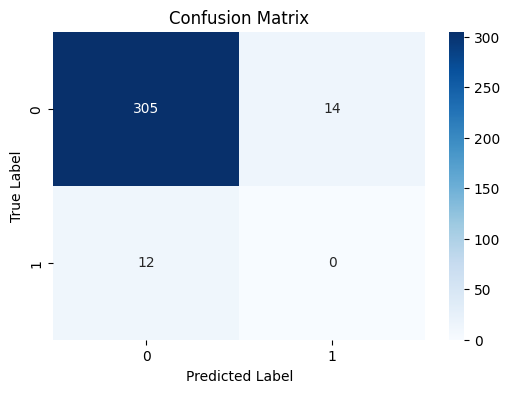

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Use the trainer's predict method
predictions = trainer.predict(tft_lightning_module, dataloaders=val_dataloader)

# Concatenate predictions from all batches
predictions = torch.cat(predictions, dim=0).cpu().numpy()

# Extract actual targets from the validation dataloader
actuals = []
for batch in val_dataloader:
    y = batch[1]
    y = y[0]
    actuals.append(y)
actuals = torch.cat(actuals, dim=0).cpu().numpy()

# Convert logits to probabilities
probabilities = np.exp(predictions) / np.exp(predictions).sum(axis=-1, keepdims=True)

# Predicted class labels
y_pred = probabilities.argmax(axis=-1).flatten()

# Actual class labels
y_true = actuals.flatten()

# Classification report
from sklearn.metrics import classification_report

print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

So, this apporach also didn't work and so I will use a different approach using Focal Loss.

## **Option 2: Use Focal Loss**

### Update the Loss Function to Focal Loss

In [ ]:
import pytorch_forecasting
print("Updated PyTorch Forecasting version:", pytorch_forecasting.__version__)

Updated PyTorch Forecasting version: 1.1.1


### Implement Focal Loss Manually

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight  # Class weights
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute log probabilities
        logpt = F.log_softmax(inputs, dim=-1)
        pt = torch.exp(logpt)

        # Create one-hot encoding for targets
        targets_one_hot = F.one_hot(targets, num_classes=inputs.size(-1))
        targets_one_hot = targets_one_hot.type_as(inputs)

        # Compute focal loss
        loss = -((1 - pt) ** self.gamma) * logpt * targets_one_hot

        # Apply class weights if provided
        if self.weight is not None:
            loss = loss * self.weight

        # Reduce loss
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss


In [ ]:
# Instantiate the FocalLoss
focal_loss = FocalLoss(gamma=10.0, reduction='mean')

# Update the loss function in your model
tft_model.hparams.loss = focal_loss

### Update the LightningModule

Ensure that the TemporalFusionTransformerLightningModule uses the updated loss function.

In [ ]:
class TemporalFusionTransformerLightningModule(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.loss = self.model.hparams.loss  # Use the updated Focal Loss
        self.save_hyperparameters(ignore=['model', 'loss'])

    def forward(self, x):
        output = self.model(x)
        return output['prediction']  # Return only the prediction tensor

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True)
        print(f"Epoch {self.current_epoch}, Training Loss: {loss.item()}")
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = recursive_to_device(x, self.device)
        y = recursive_to_device(y[0], self.device).long()
        y_pred = self(x)
        loss = self.loss(y_pred.view(-1, y_pred.size(-1)), y.view(-1))
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        print(f"Epoch {self.current_epoch}, Validation Loss: {loss.item()}")
        return loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        if isinstance(batch, tuple) or isinstance(batch, list):
            x = batch[0]
        else:
            x = batch
        x = recursive_to_device(x, self.device)
        y_pred = self(x)
        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), lr=self.model.hparams.learning_rate
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            patience=self.model.hparams.reduce_on_plateau_patience,
            factor=0.5,
            verbose=True,  # Set verbose to True
        )
        scheduler_config = {
            'scheduler': scheduler,
            'monitor': 'val_loss',
            'interval': 'epoch',
            'frequency': 1,
        }
        return {'optimizer': optimizer, 'lr_scheduler': scheduler_config}

### Define the Trainer

Include necessary callbacks and settings.

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

# Early stopping callback with verbose output
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=5,
    verbose=True,
    mode="min",
)

# Learning rate monitor
lr_logger = LearningRateMonitor(logging_interval='epoch')

# Define the trainer
trainer = pl.Trainer(
    max_epochs=30,
    accelerator="gpu",
    devices=1,
    callbacks=[lr_logger, early_stop_callback],
    gradient_clip_val=0.1,
    precision=32,
    logger=True,
    enable_progress_bar=True,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Train the Model

In [ ]:
# Instantiate the LightningModule
tft_lightning_module = TemporalFusionTransformerLightningModule(tft_model)

# Train the model
try:
    trainer.fit(
        tft_lightning_module,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
except Exception as e:
    print(f"An exception occurred during training: {e}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                            | Params | Mode 
------------------------------------------------------------------
0 | model | CustomTemporalFusionTransformer | 31.5 K | train
1 | loss  | FocalLoss                       | 0      | train
------------------------------------------------------------------
31.5 K    Trainable params
0         Non-trainable params
31.5 K    Total params
0.126     Total estimated model params size (MB)
518       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Validation Loss: 4.684126452048076e-06
Epoch 0, Validation Loss: 5.124007657286711e-06


Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, Training Loss: 0.00016284229059237987
Epoch 0, Training Loss: 0.00016502526705153286
Epoch 0, Training Loss: 0.00018975815328303725
Epoch 0, Training Loss: 0.00019619095837697387
Epoch 0, Training Loss: 0.00018936165724880993
Epoch 0, Training Loss: 0.0001825534855015576
Epoch 0, Training Loss: 0.0001193127827718854
Epoch 0, Training Loss: 0.00022644891578238457
Epoch 0, Training Loss: 0.00022562667436432093
Epoch 0, Training Loss: 0.00025627517607063055
Epoch 0, Training Loss: 0.0002390683366684243
Epoch 0, Training Loss: 0.00020464701810851693
Epoch 0, Training Loss: 0.00019045203225687146
Epoch 0, Training Loss: 0.00020131673954892904
Epoch 0, Training Loss: 0.000219058696529828
Epoch 0, Training Loss: 0.00018261873628944159
Epoch 0, Training Loss: 0.00018897929112426937
Epoch 0, Training Loss: 0.00030476998654194176
Epoch 0, Training Loss: 0.00021897663827985525
Epoch 0, Training Loss: 0.00022879563039168715
Epoch 0, Training Loss: 0.00041935587069019675
Epoch 0, Training 

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.000


Epoch 0, Validation Loss: 2.587096969364211e-05
Epoch 0, Validation Loss: 2.064689397229813e-05
Epoch 0, Validation Loss: 4.7374331188621e-05
Epoch 0, Validation Loss: 0.00022490692208521068
Epoch 0, Validation Loss: 0.0001936779881361872
Epoch 0, Validation Loss: 6.175706948852167e-05
Epoch 1, Training Loss: 0.00015021840226836503
Epoch 1, Training Loss: 0.00018149106472264975
Epoch 1, Training Loss: 0.0001992721518035978
Epoch 1, Training Loss: 0.00010554600157774985
Epoch 1, Training Loss: 0.00014162209117785096
Epoch 1, Training Loss: 0.00020961655536666512
Epoch 1, Training Loss: 0.00012830214109271765
Epoch 1, Training Loss: 0.00012860598508268595
Epoch 1, Training Loss: 0.00022731974604539573
Epoch 1, Training Loss: 0.00018383614951744676
Epoch 1, Training Loss: 0.00016313114610966295
Epoch 1, Training Loss: 0.0001701039873296395
Epoch 1, Training Loss: 0.0001505798427388072
Epoch 1, Training Loss: 0.00017834961181506515
Epoch 1, Training Loss: 0.00019520154455676675
Epoch 1, Tr

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, Validation Loss: 2.6106172299478203e-05
Epoch 1, Validation Loss: 2.509419027774129e-05
Epoch 1, Validation Loss: 5.86431342526339e-05
Epoch 1, Validation Loss: 0.00024280653451569378
Epoch 1, Validation Loss: 0.00019792470266111195
Epoch 1, Validation Loss: 8.289711695397273e-05
Epoch 2, Training Loss: 0.00020459358347579837
Epoch 2, Training Loss: 0.00018193875439465046
Epoch 2, Training Loss: 0.00021071499213576317
Epoch 2, Training Loss: 0.00017795662279240787
Epoch 2, Training Loss: 0.0001803128980100155
Epoch 2, Training Loss: 0.00018734710465651006
Epoch 2, Training Loss: 0.00019129819702357054
Epoch 2, Training Loss: 0.00019270711345598102
Epoch 2, Training Loss: 0.00015244529640767723
Epoch 2, Training Loss: 0.00018004071898758411
Epoch 2, Training Loss: 0.0001370644458802417
Epoch 2, Training Loss: 0.00022787746274843812
Epoch 2, Training Loss: 0.0002235962456325069
Epoch 2, Training Loss: 0.0001778247533366084
Epoch 2, Training Loss: 0.00019973207963630557
Epoch 2, 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, Validation Loss: 2.1509566067834385e-05
Epoch 2, Validation Loss: 1.6113950550789014e-05
Epoch 2, Validation Loss: 4.0051050746114925e-05
Epoch 2, Validation Loss: 0.0002933202777057886
Epoch 2, Validation Loss: 0.00019327187328599393
Epoch 2, Validation Loss: 6.844496965641156e-05
Epoch 3, Training Loss: 0.00018034418462775648
Epoch 3, Training Loss: 0.00018553779227659106
Epoch 3, Training Loss: 0.000153157816384919
Epoch 3, Training Loss: 0.00016768538625910878
Epoch 3, Training Loss: 0.0001375627616653219
Epoch 3, Training Loss: 0.00012637618056032807
Epoch 3, Training Loss: 0.00021460099378600717
Epoch 3, Training Loss: 0.00016112513549160212
Epoch 3, Training Loss: 0.00018621263734530658
Epoch 3, Training Loss: 0.00015615657321177423
Epoch 3, Training Loss: 0.00016262210556305945
Epoch 3, Training Loss: 0.00015739889931865036
Epoch 3, Training Loss: 0.00022502054343931377
Epoch 3, Training Loss: 0.00018538188305683434
Epoch 3, Training Loss: 0.0002699712640605867
Epoch 3

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, Validation Loss: 3.684384864754975e-05
Epoch 3, Validation Loss: 3.246941923862323e-05
Epoch 3, Validation Loss: 6.0542133724084124e-05
Epoch 3, Validation Loss: 0.00021542739705182612
Epoch 3, Validation Loss: 0.00020121713168919086
Epoch 3, Validation Loss: 9.127594239544123e-05
Epoch 4, Training Loss: 0.00018620703485794365
Epoch 4, Training Loss: 0.00016624992713332176
Epoch 4, Training Loss: 0.00019456198788248003
Epoch 4, Training Loss: 0.00014929093595128506
Epoch 4, Training Loss: 0.00018152096890844405
Epoch 4, Training Loss: 0.00014968638424761593
Epoch 4, Training Loss: 0.00016333941312041134
Epoch 4, Training Loss: 0.0001757092250045389
Epoch 4, Training Loss: 0.00014370118151418865
Epoch 4, Training Loss: 0.00017809192650020123
Epoch 4, Training Loss: 0.00019667176820803434
Epoch 4, Training Loss: 0.00020510122703853995
Epoch 4, Training Loss: 0.00019052939023822546
Epoch 4, Training Loss: 0.0001342387986369431
Epoch 4, Training Loss: 0.00020387175027281046
Epoch 

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 4, Validation Loss: 1.656377935432829e-05
Epoch 4, Validation Loss: 1.9745486497413367e-05
Epoch 4, Validation Loss: 4.568164877127856e-05
Epoch 4, Validation Loss: 0.00021550375095102936
Epoch 4, Validation Loss: 0.00022088474361225963
Epoch 4, Validation Loss: 7.255483797052875e-05
Epoch 5, Training Loss: 0.00018472732335794717
Epoch 5, Training Loss: 0.0001676717947702855
Epoch 5, Training Loss: 0.00012803584104403853
Epoch 5, Training Loss: 0.00013034569565206766
Epoch 5, Training Loss: 0.00018700069631449878
Epoch 5, Training Loss: 0.0003055861743632704
Epoch 5, Training Loss: 0.00012349736061878502
Epoch 5, Training Loss: 0.0001500787475379184
Epoch 5, Training Loss: 0.00017129865591414273
Epoch 5, Training Loss: 0.00014461527462117374
Epoch 5, Training Loss: 0.00016877581947483122
Epoch 5, Training Loss: 0.00017428849241696298
Epoch 5, Training Loss: 0.00019846350187435746
Epoch 5, Training Loss: 0.00017466781719122082
Epoch 5, Training Loss: 0.0001571081520523876
Epoch 5,

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 5, Validation Loss: 2.6939356757793576e-05
Epoch 5, Validation Loss: 2.6597837859299034e-05
Epoch 5, Validation Loss: 6.157349707791582e-05
Epoch 5, Validation Loss: 0.00019487742974888533
Epoch 5, Validation Loss: 0.00020571800996549428
Epoch 5, Validation Loss: 0.00010404153726994991


### Evaluate the Model
After training, evaluate the model using appropriate metrics.

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Classification Report:
              precision    recall  f1-score   support

         0.0     0.9637    1.0000    0.9815       319
         1.0     0.0000    0.0000    0.0000        12

    accuracy                         0.9637       331
   macro avg     0.4819    0.5000    0.4908       331
weighted avg     0.9288    0.9637    0.9460       331



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


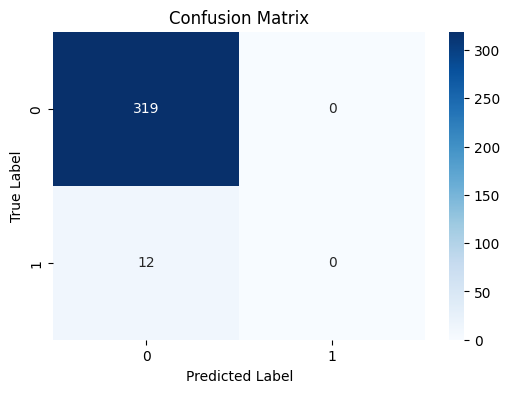

In [ ]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Use the trainer's predict method
predictions = trainer.predict(tft_lightning_module, dataloaders=val_dataloader)

# Concatenate predictions from all batches
predictions = torch.cat(predictions, dim=0).cpu().numpy()

# Extract actual targets from the validation dataloader
actuals = []
for batch in val_dataloader:
    y = batch[1]
    y = y[0]
    actuals.append(y)
actuals = torch.cat(actuals, dim=0).cpu().numpy()

# Convert logits to probabilities
probabilities = np.exp(predictions) / np.exp(predictions).sum(axis=-1, keepdims=True)

# Predicted class labels
y_pred = probabilities.argmax(axis=-1).flatten()

# Actual class labels
y_true = actuals.flatten()

# Classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Graph Neural Network

## Step 1: Data Preparation

In [ ]:
df.columns.tolist()

['date',
 'dewpoint_2m_temperature',
 'district',
 'latitude',
 'longitude',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'ssm_interpolated',
 'LC_Type1_filled',
 'elevation_filled',
 'precipitationCal_interpolated',
 'year',
 'month',
 'day',
 'dayofweek',
 'precipitationCal_lag1',
 'precipitationCal_lag7',
 'extreme_precipitation',
 'time_idx',
 'location_id']

In [ ]:
# Check data types
print(df.dtypes)

date                             datetime64[ns]
dewpoint_2m_temperature                 float64
district                                  int64
latitude                                float64
longitude                               float64
maximum_2m_air_temperature              float64
mean_2m_air_temperature                 float64
mean_sea_level_pressure                 float64
minimum_2m_air_temperature              float64
surface_pressure                        float64
total_precipitation                     float64
u_component_of_wind_10m                 float64
v_component_of_wind_10m                 float64
ssm_interpolated                        float64
LC_Type1_filled                           int64
elevation_filled                        float64
precipitationCal_interpolated           float64
year                                      int32
month                                     int32
day                                       int32
dayofweek                               

In [ ]:
# List of feature columns
feature_columns = [
    'dewpoint_2m_temperature',
    'maximum_2m_air_temperature',
    'mean_2m_air_temperature',
    'mean_sea_level_pressure',
    'minimum_2m_air_temperature',
    'surface_pressure',
    'total_precipitation',
    'u_component_of_wind_10m',
    'v_component_of_wind_10m',
    'ssm_interpolated',
    'elevation_filled',
    'precipitationCal_lag1',
    'precipitationCal_lag7',
    'month',
    'day',
    'dayofweek',
    # Add any other features you have
]

# Combine features into a list for each sample
df['features'] = df[feature_columns].values.tolist()

In [ ]:
df['features']


,features
22159,"[0.2781301057340961, 1.0296248101380725, 1.242..."
16470,"[-2.098234069852808, -1.3204195764658888, -1.9..."
34562,"[-0.4509166591085567, 1.4244383633553266, 1.00..."
15250,"[-0.33505949076925456, 0.5193119378512753, -0...."
34959,"[-1.339967205192283, 1.201634927306255, 0.9986..."
...,...
23988,"[-1.2154916897225705, -1.1064976182663984, -1...."
33051,"[-1.7166005784406397, -1.0325046136429439, -1...."
12199,"[-0.5773436974902845, -0.33461118585057803, -0..."
9149,"[-1.4213615337824734, -1.4055979847032016, -1...."


In [ ]:
# Display the first few rows
print(df.head())

            date  dewpoint_2m_temperature  district   latitude  longitude  \
22159 2015-06-01                 0.278130         6  23.202703  90.702703   
16470 2015-06-01                -2.098234        23  25.905405  89.801802   
34562 2015-06-01                -0.450917         1  21.400901  92.504505   
15250 2015-06-01                -0.335059        17  25.004505  89.801802   
34959 2015-06-01                -1.339967         1  21.851351  92.504505   

       maximum_2m_air_temperature  mean_2m_air_temperature  \
22159                    1.029625                 1.242027   
16470                   -1.320420                -1.943701   
34562                    1.424438                 1.006483   
15250                    0.519312                -0.082324   
34959                    1.201635                 0.998662   

       mean_sea_level_pressure  minimum_2m_air_temperature  surface_pressure  \
22159                 0.401391                    0.895034          0.491407   
1647

## Step 2: Graph Construction Using Geographical Coordinates

We'll construct a spatial graph where each node represents a location, and edges are defined based on geographical proximity.

- **2.1 Calculate Pairwise Distances**

I use the Haversine formula to calculate the great-circle distance between two points on the Earth's surface.

In [ ]:
import numpy as np
from sklearn.metrics.pairwise import haversine_distances

# Convert latitude and longitude to radians
df['lat_rad'] = np.deg2rad(df['latitude'])
df['lon_rad'] = np.deg2rad(df['longitude'])

# Get unique locations with their coordinates
locations_df = df[['location_id', 'lat_rad', 'lon_rad']].drop_duplicates().reset_index(drop=True)

# Prepare coordinate array
coords = locations_df[['lat_rad', 'lon_rad']].values

# Calculate pairwise haversine distances (in radians)
distance_matrix = haversine_distances(coords, coords)

# Convert distances from radians to kilometers (Earth's radius ~6371 km)
distance_matrix_km = distance_matrix * 6371.0

In [ ]:
distance_matrix_km

array([[  0.        , 314.03199405, 272.93944668, ..., 170.98618947,
        157.08798509, 191.13280319],
       [314.03199405,   0.        , 571.48406736, ..., 403.30101675,
        156.94554707, 444.84317859],
       [272.93944668, 571.48406736,   0.        , ..., 340.48336543,
        419.60801402, 150.26341438],
       ...,
       [170.98618947, 403.30101675, 340.48336543, ...,   0.        ,
        266.77097433, 327.70552079],
       [157.08798509, 156.94554707, 419.60801402, ..., 266.77097433,
          0.        , 304.56032177],
       [191.13280319, 444.84317859, 150.26341438, ..., 327.70552079,
        304.56032177,   0.        ]])

## 2.2 Define Edges Based on a Distance Threshold
We'll define edges between nodes (locations) that are within a certain distance threshold.

In [ ]:
import networkx as nx

# Define a distance threshold in kilometers
distance_threshold = 60  # Adjust as needed

# Initialize an empty list to store edges
edges = []

num_locations = len(locations_df)
for i in range(num_locations):
    for j in range(i + 1, num_locations):
        if distance_matrix_km[i, j] <= distance_threshold:
            loc1 = locations_df.iloc[i]['location_id']
            loc2 = locations_df.iloc[j]['location_id']
            edges.append((loc1, loc2))

# Create a NetworkX graph
G = nx.Graph()
G.add_nodes_from(locations_df['location_id'])
G.add_edges_from(edges)

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

Number of nodes: 65
Number of edges: 100


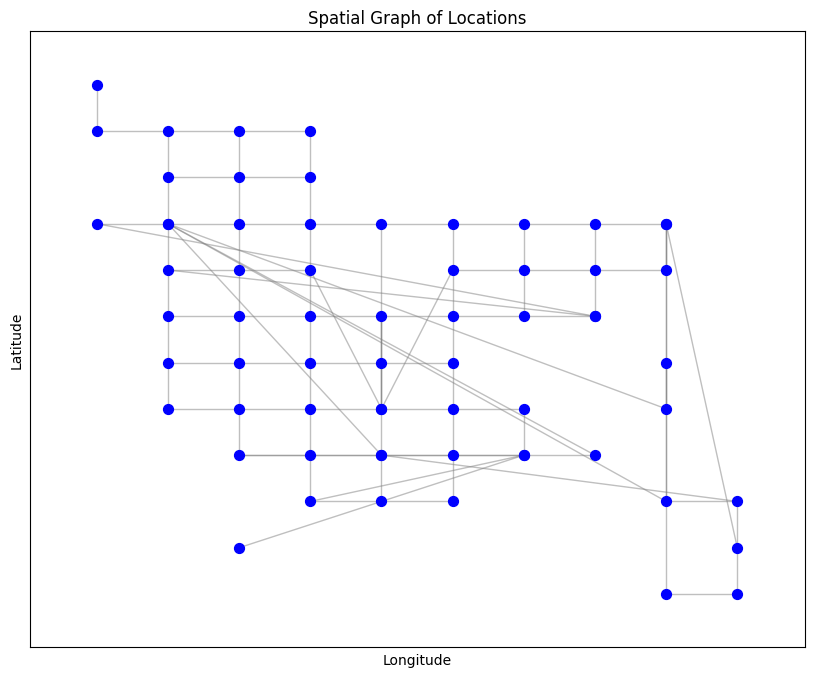

In [ ]:
import matplotlib.pyplot as plt

# Plot the graph
pos = {loc_id: (lon, lat) for loc_id, lon, lat in zip(locations_df['location_id'], df['longitude'], df['latitude'])}

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='blue')
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)
plt.title('Spatial Graph of Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
isolated_nodes = list(nx.isolates(G))
print(f"Number of isolated nodes: {len(isolated_nodes)}")

Number of isolated nodes: 0


## Convert Graph to PyTorch Geometric Format

In [ ]:
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

PyTorch version: 2.0.1+cu117
CUDA available: True
CUDA version: 11.7


Install PyTorch Geometric

In [ ]:
# Install PyTorch Geometric
!pip install --verbose --no-cache-dir torch-geometric

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)


### Install Dependencies
Based on the PyTorch and CUDA versions, install the required packages:

In [ ]:
# Get PyTorch and CUDA versions
import torch
torch_version = torch.__version__.split('+')[0]
print(f"PyTorch version: {torch_version}")

if torch.cuda.is_available():
    cuda_version = torch.version.cuda.replace('.', '')
    print(f"CUDA version: cu{cuda_version}")
    cuda_str = f"+cu{cuda_version}"
else:
    print("CUDA not available. Using CPU.")
    cuda_str = "+cpu"

# Define the URL for wheels
whl_url = f"https://data.pyg.org/whl/torch-{torch_version}{cuda_str}.html"
print(f"Wheel URL: {whl_url}")

PyTorch version: 2.0.1
CUDA version: cu117
Wheel URL: https://data.pyg.org/whl/torch-2.0.1+cu117.html


### Install the packages:

In [ ]:
# Install torch-scatter
!pip install --verbose --no-cache-dir torch-scatter -f {whl_url}

# Install torch-sparse
!pip install --verbose --no-cache-dir torch-sparse -f {whl_url}

# Install torch-cluster
!pip install --verbose --no-cache-dir torch-cluster -f {whl_url}

# Install torch-spline-conv
!pip install --verbose --no-cache-dir torch-spline-conv -f {whl_url}

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in links: https://data.pyg.org/whl/torch-2.5.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.8 MB/s eta 0:00:00
  Running command python setup.py egg_info
  running egg_info
  creating /tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info
  writing /tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/PKG-INFO
  writing dependency_links to /tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/dependency_links.txt
  writing requirements to /tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/requires.txt
  writing top-level names to /tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/top_level.txt
  writing manifest file '/tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/SOURCES.txt'
  reading manifest file '/tmp/pip-pip-egg-info-636q0l3a/torch_scatter.egg-info/SOURCES.txt'
  reading manifest template 'MANIFEST.in'
  adding license file 'LICENSE'
  writing manifest 

## Use a different approach with different versions

- **Step 1: Uninstall Existing PyTorch Packages**

In [ ]:
!pip uninstall -y torch torchvision torchtext torchaudio

Found existing installation: torch 2.0.1+cu117
Uninstalling torch-2.0.1+cu117:
  Successfully uninstalled torch-2.0.1+cu117
Found existing installation: torchvision 0.15.2+cu117
Uninstalling torchvision-0.15.2+cu117:
  Successfully uninstalled torchvision-0.15.2+cu117
Found existing installation: torchtext 0.15.2+cpu
Uninstalling torchtext-0.15.2+cpu:
  Successfully uninstalled torchtext-0.15.2+cpu


- **Step 2: Install Compatible PyTorch Version**

In [ ]:
!pip install torch==2.0.1+cu117 torchvision==0.15.2+cu117 torchtext==0.15.2 --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117
  Using cached https://download.pytorch.org/whl/cu117/torch-2.0.1%2Bcu117-cp310-cp310-linux_x86_64.whl (1843.9 MB)
  Using cached https://download.pytorch.org/whl/cu117/torchvision-0.15.2%2Bcu117-cp310-cp310-linux_x86_64.whl (6.1 MB)
  Using cached https://download.pytorch.org/whl/torchtext-0.15.2%2Bcpu-cp310-cp310-linux_x86_64.whl (2.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lightning 2.4.0 requires torch<4.0,>=2.1.0, but you have torch 2.0.1+cu117 which is incompatible.
pytorch-forecasting 1.1.1 requires torch!=2.0.1,<3.0.0,>=2.0.0, but you have torch 2.0.1+cu117 which is incompatible.
pytorch-lightning 2.4.0 requires torch>=2.1.0, but you have torch 2.0.1+cu117 which is incompatible.


- **Step 3: Install PyG and Dependencies**

In [ ]:
# Install PyG dependencies
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.1+cu117.html

# Install PyG
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.0.1+cu117.html


- **Step 4: Restart the Runtime**

In [ ]:
import os
os._exit(00)

In [ ]:
import torch
import torch_geometric
from torch_geometric.utils import from_networkx

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch Geometric version: {torch_geometric.__version__}")
print("Successfully imported from_networkx.")

PyTorch version: 2.0.1+cu117
CUDA version: 11.7
PyTorch Geometric version: 2.6.1
Successfully imported from_networkx.


## Step 5: GNN Implementation

In [ ]:
import torch
from torch_geometric.utils import from_networkx

# Convert NetworkX graph to PyTorch Geometric Data
data_pg = from_networkx(G)

# Get edge_index tensor
edge_index = data_pg.edge_index

# Step 6: GNN Model Implementation

- 6.1 Prepare Data for GNN

In [ ]:
from torch_geometric.data import Data, DataLoader

# Sort the DataFrame by time_idx and location_id
df.sort_values(['time_idx', 'location_id'], inplace=True)

# Get unique time steps
time_steps = df['time_idx'].unique()

graph_data_list = []

for time in time_steps:
    df_time = df[df['time_idx'] == time]

    # Ensure that the nodes are in the same order as in the edge_index
    df_time = df_time.merge(locations_df[['location_id']], on='location_id', how='inner')

    # Node features
    x = torch.tensor(df_time.sort_values('location_id')['features'].tolist(), dtype=torch.float)

    # Node labels
    y = torch.tensor(df_time.sort_values('location_id')['extreme_precipitation'].values, dtype=torch.long)

    # Create Data object
    graph_data = Data(x=x, edge_index=edge_index, y=y)
    graph_data_list.append(graph_data)

- **6.2 Split Data into Training and Validation Sets**

In [ ]:
# Define train and validation split
train_ratio = 0.8
train_size = int(len(graph_data_list) * train_ratio)
train_graphs = graph_data_list[:train_size]
val_graphs = graph_data_list[train_size:]

# Create DataLoaders
batch_size = 1  # Process one graph at a time due to temporal dependencies
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


- **4.2 Define Utility Functions for Data Inspection and Validation**

In [ ]:
def check_edge_index(edge_index, num_nodes):
    """
    Ensure that all node indices in edge_index are within [0, num_nodes - 1].
    """
    if edge_index.min() < 0:
        raise ValueError("Negative node index found in edge_index.")
    if edge_index.max() >= num_nodes:
        raise ValueError(f"Node index {edge_index.max()} in edge_index exceeds num_nodes {num_nodes}.")

def check_labels(labels, num_classes):
    """
    Ensure that labels are within [0, num_classes - 1].
    """
    if labels.min() < 0:
        raise ValueError("Negative label found.")
    if labels.max() >= num_classes:
        raise ValueError(f"Label {labels.max()} exceeds number of classes {num_classes - 1}.")

def inspect_data(data):
    """
    Print detailed information about the data object.
    """
    print("----- Data Inspection -----")
    print(f"Data Keys: {data.keys}")
    print(f"Number of Nodes: {data.num_nodes}")
    print(f"Edge Index Shape: {data.edge_index.shape}")
    print(f"Node Features Shape: {data.x.shape}")
    print(f"Labels Shape: {data.y.shape}")
    print(f"Labels Unique Values: {torch.unique(data.y)}")
    print("---------------------------\n")

- **4.3 Training Loop**

In [ ]:
device = torch.device('cpu')  # Switch to CPU for debugging

- **4.4 Execute the Training Loop with Error Handling**

# Different approach

## Data Preparation

In [ ]:
import torch
from torch_geometric.data import Data
import pandas as pd
from torch_geometric.utils import from_networkx

# Assuming G, df, and locations_df are already defined
# G: NetworkX graph
# df: DataFrame containing 'time_idx', 'location_id', 'features', 'extreme_precipitation'
# locations_df: DataFrame containing 'location_id'

# Convert NetworkX graph to PyTorch Geometric Data to get the global edge_index
data_pg = from_networkx(G)
global_edge_index = data_pg.edge_index.numpy().T  # Shape: [num_edges, 2]

# Sort the DataFrame by time_idx and location_id
df_sorted = df.sort_values(['time_idx', 'location_id'])

# Get unique time steps
time_steps = df_sorted['time_idx'].unique()

# Initialize a list to hold Data objects
graph_data_list = []

# Create a mapping from location_id to global node index
# Assuming that location_id corresponds to a unique node in G
location_to_global_idx = {loc: idx for idx, loc in enumerate(sorted(locations_df['location_id']))}

for time in time_steps:
    df_time = df_sorted[df_sorted['time_idx'] == time]

    # Get the location_ids present in this time step
    location_ids = df_time['location_id'].unique()

    # Get the global node indices for these location_ids
    global_node_indices = [location_to_global_idx[loc] for loc in location_ids]

    # Create a mapping from global to local node indices
    global_to_local = {global_idx: local_idx for local_idx, global_idx in enumerate(global_node_indices)}

    # Filter edges where both source and target nodes are present in this time step
    mask = [(edge[0] in global_to_local) and (edge[1] in global_to_local) for edge in global_edge_index]
    filtered_edges = global_edge_index[mask]

    # Remap global node indices to local node indices
    remapped_edges = [
        [global_to_local[edge[0]], global_to_local[edge[1]]]
        for edge in filtered_edges
    ]

    if len(remapped_edges) == 0:
        # If no edges are present, create an empty edge_index
        remapped_edge_index = torch.empty((2, 0), dtype=torch.long)
    else:
        remapped_edge_index = torch.tensor(remapped_edges, dtype=torch.long).t().contiguous()

    # Node features
    x = torch.tensor(
        df_time.sort_values('location_id')['features'].tolist(),
        dtype=torch.float
    )

    # Node labels
    y = torch.tensor(
        df_time.sort_values('location_id')['extreme_precipitation'].values,
        dtype=torch.long
    )

    # Create Data object
    graph_data = Data(x=x, edge_index=remapped_edge_index, y=y)
    graph_data_list.append(graph_data)

# Define train and validation split
train_ratio = 0.8
train_size = int(len(graph_data_list) * train_ratio)
train_graphs = graph_data_list[:train_size]
val_graphs = graph_data_list[train_size:]

# Create DataLoaders
batch_size = 1  # Process one graph at a time due to temporal dependencies
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

## Ensure Data Consistency

In [ ]:
def check_edge_index(edge_index, num_nodes):
    """
    Ensure that all node indices in edge_index are within [0, num_nodes - 1].
    """
    if edge_index.numel() == 0:
        print("Warning: edge_index is empty.")
        return
    if edge_index.min() < 0:
        raise ValueError("Negative node index found in edge_index.")
    if edge_index.max() >= num_nodes:
        raise ValueError(f"Node index {edge_index.max()} in edge_index exceeds num_nodes {num_nodes}.")

def check_labels(labels, num_classes):
    """
    Ensure that labels are within [0, num_classes - 1].
    """
    if labels.min() < 0:
        raise ValueError("Negative label found.")
    if labels.max() >= num_classes:
        raise ValueError(f"Label {labels.max()} exceeds number of classes {num_classes - 1}.")

def inspect_data(data):
    """
    Print detailed information about the data object.
    """
    print("----- Data Inspection -----")
    print(f"Data Keys: {data.keys}")
    print(f"Number of Nodes: {data.num_nodes}")
    print(f"Edge Index Shape: {data.edge_index.shape}")
    print(f"Node Features Shape: {data.x.shape}")
    print(f"Labels Shape: {data.y.shape}")
    print(f"Labels Unique Values: {torch.unique(data.y)}")
    print("---------------------------\n")

### Applying the Checks

In [ ]:
# Inspect the first training graph
print("Inspecting the first training graph:")
inspect_data(train_graphs[0])
check_edge_index(train_graphs[0].edge_index, train_graphs[0].num_nodes)
check_labels(train_graphs[0].y, num_classes)

# Inspect the first validation graph
print("Inspecting the first validation graph:")
inspect_data(val_graphs[0])
check_edge_index(val_graphs[0].edge_index, val_graphs[0].num_nodes)
check_labels(val_graphs[0].y, num_classes)

Inspecting the first training graph:
----- Data Inspection -----
Data Keys: <bound method BaseData.keys of Data(x=[59, 16], edge_index=[2, 166], y=[59])>
Number of Nodes: 59
Edge Index Shape: torch.Size([2, 166])
Node Features Shape: torch.Size([59, 16])
Labels Shape: torch.Size([59])
Labels Unique Values: tensor([0, 1])
---------------------------

Inspecting the first validation graph:
----- Data Inspection -----
Data Keys: <bound method BaseData.keys of Data(x=[59, 16], edge_index=[2, 164], y=[59])>
Number of Nodes: 59
Edge Index Shape: torch.Size([2, 164])
Node Features Shape: torch.Size([59, 16])
Labels Shape: torch.Size([59])
Labels Unique Values: tensor([0, 1])
---------------------------



**Define the GNN Model**

We'll define a GNN model that processes node features and outputs predictions for each node.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class SpatioTemporalGNN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(SpatioTemporalGNN, self).__init__()
        self.num_classes = num_classes  # Add this line to store the number of classes
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Node-level predictions
        x = self.fc(x)

        return F.log_softmax(x, dim=1)

In [ ]:
class SpatioTemporalGNN_SingleOutput(nn.Module):
    def __init__(self, num_node_features):
        super(SpatioTemporalGNN_SingleOutput, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, 1)  # Single output neuron

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Node-level predictions
        x = self.fc(x)

        return torch.sigmoid(x).squeeze(1)  # Sigmoid activation


## Training and Evaluation

**Define Loss Function and Optimizer**

In [ ]:
# Calculate class weights
from collections import Counter

all_labels = []
for graph_data in train_graphs:
    all_labels.extend(graph_data.y.tolist())

label_counts = Counter(all_labels)
total_counts = sum(label_counts.values())
class_weights = [total_counts / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Normalize class weights
class_weights = class_weights / class_weights.min()
print(f"Class weights: {class_weights}")

# Cap the maximum class weight
max_weight = 10.0
class_weights = torch.clamp(class_weights, max=max_weight)

# Define the loss function
criterion = nn.NLLLoss(weight=class_weights)

# Initialize the model and optimizer
# Assuming all graphs have the same number of node features and classes
num_node_features = train_graphs[0].x.size(1)
num_classes = len(label_counts)

# Initialize the model and move it to the device
model = SpatioTemporalGNN(num_node_features=num_node_features, num_classes=num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Class weights: tensor([1.0000, 3.8366])


In [ ]:
num_classes

2

**Define Utility Functions for Data Inspection and Validation**

In [ ]:
def check_edge_index(edge_index, num_nodes):
    """
    Ensure that all node indices in edge_index are within [0, num_nodes - 1].
    """
    if edge_index.min() < 0:
        raise ValueError("Negative node index found in edge_index.")
    if edge_index.max() >= num_nodes:
        raise ValueError(f"Node index {edge_index.max()} in edge_index exceeds num_nodes {num_nodes}.")

def check_labels(labels, num_classes):
    """
    Ensure that labels are within [0, num_classes - 1].
    """
    if labels.min() < 0:
        raise ValueError("Negative label found.")
    if labels.max() >= num_classes:
        raise ValueError(f"Label {labels.max()} exceeds number of classes {num_classes - 1}.")

def inspect_data(data):
    """
    Print detailed information about the data object.
    """
    print("----- Data Inspection -----")
    print(f"Data Keys: {data.keys}")
    print(f"Number of Nodes: {data.num_nodes}")
    print(f"Edge Index Shape: {data.edge_index.shape}")
    print(f"Node Features Shape: {data.x.shape}")
    print(f"Labels Shape: {data.y.shape}")
    print(f"Labels Unique Values: {torch.unique(data.y)}")
    print("---------------------------\n")

## Define Training and Validation

In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        inspect_data(batch)  # Inspect data

        num_nodes = batch.num_nodes
        edge_index = batch.edge_index

        # Check edge_index validity
        check_edge_index(edge_index, num_nodes)

        labels = batch.y
        check_labels(labels, model.num_classes)

        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)

        # Check for train_mask
        if hasattr(batch, 'train_mask'):
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        else:
            # If no train_mask is provided, assume all nodes are to be trained
            loss = criterion(out, batch.y)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inspect_data(batch)  # Inspect data

            num_nodes = batch.num_nodes
            edge_index = batch.edge_index

            # Check edge_index validity
            check_edge_index(edge_index, num_nodes)

            labels = batch.y
            check_labels(labels, model.num_classes)

            batch = batch.to(device)
            out = model(batch)

            # Check for val_mask
            if hasattr(batch, 'val_mask'):
                preds = out[batch.val_mask].argmax(dim=1)
                true = batch.y[batch.val_mask]
            else:
                # If no val_mask is provided, assume all nodes are to be validated
                preds = out.argmax(dim=1)
                true = batch.y

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true.cpu().numpy())
    return all_labels, all_preds

## Execute the Training Loop with Error Handling

In [ ]:
# Set device to CPU for debugging
device = torch.device('cpu')

In [ ]:
# Initialize the model and move it to the CPU
model = SpatioTemporalGNN(num_node_features=num_node_features, num_classes=num_classes).to(device)

In [ ]:
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cpu


In [ ]:
sample_batch = train_loader.dataset[0].to(device)  # Ensure it's moved to CPU
print(f"Sample batch is on device: {sample_batch.x.device}")

Sample batch is on device: cpu


In [ ]:
# Ensure model parameters are on CPU
for param in model.parameters():
    assert param.device.type == 'cpu', "Model parameters are not on CPU."

In [ ]:
# Check unique label values in training and validation sets
train_labels = torch.cat([graph.y for graph in train_graphs])
val_labels = torch.cat([graph.y for graph in val_graphs])

print(f"Unique labels in training set: {torch.unique(train_labels)}")
print(f"Unique labels in validation set: {torch.unique(val_labels)}")

# Ensure labels are of type torch.long
if not train_labels.dtype == torch.long:
    print("Converting training labels to torch.long.")
    train_labels = train_labels.type(torch.long)

if not val_labels.dtype == torch.long:
    print("Converting validation labels to torch.long.")
    val_labels = val_labels.type(torch.long)

Unique labels in training set: tensor([0, 1])
Unique labels in validation set: tensor([0, 1])


In [ ]:
def inspect_edge_index(edge_index, num_nodes):
    min_idx = edge_index.min().item()
    max_idx = edge_index.max().item()
    print(f"Edge Index - Min: {min_idx}, Max: {max_idx}, Num Nodes: {num_nodes}")
    if min_idx < 0 or max_idx >= num_nodes:
        raise ValueError(f"Invalid node index in edge_index: min={min_idx}, max={max_idx}, num_nodes={num_nodes}")

# Inspect edge_index for all training graphs
for idx, graph in enumerate(train_graphs):
    print(f"Training Graph {idx+1}:")
    inspect_edge_index(graph.edge_index, graph.num_nodes)

# Inspect edge_index for all validation graphs
for idx, graph in enumerate(val_graphs):
    print(f"Validation Graph {idx+1}:")
    inspect_edge_index(graph.edge_index, graph.num_nodes)

Training Graph 1:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 2:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 3:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 4:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 5:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 6:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 7:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 8:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 9:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 10:
Edge Index - Min: 0, Max: 57, Num Nodes: 59
Training Graph 11:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 12:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 13:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 14:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 15:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
Training Graph 16:
Edge Index - Min: 0, Max: 58, Num Nodes: 59
T

In [ ]:
# Check a sample model output
sample_graph = train_graphs[0].to(device)
model.eval()
with torch.no_grad():
    out = model(sample_graph)
print(f"Model output shape: {out.shape}")  # Should be [num_nodes, num_classes]

Model output shape: torch.Size([59, 2])


In [ ]:
# Confirm loss function
print(f"Loss function: {criterion}")

Loss function: NLLLoss()


In [ ]:
class SpatioTemporalGNN_SingleOutput(nn.Module):
    def __init__(self, num_node_features):
        super(SpatioTemporalGNN_SingleOutput, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, 1)  # Single output neuron

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Node-level predictions
        x = self.fc(x)

        return torch.sigmoid(x).squeeze(1)  # Sigmoid activation

In [ ]:
criterion = nn.BCELoss()  # If using sigmoid activation
# criterion = nn.BCEWithLogitsLoss()  # If NOT using sigmoid in the model


In [ ]:
# Calculate class weights
from collections import Counter

all_labels = []
for graph_data in train_graphs:
    all_labels.extend(graph_data.y.tolist())

label_counts = Counter(all_labels)
total_counts = sum(label_counts.values())
class_weights = [total_counts / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Normalize class weights
class_weights = class_weights / class_weights.min()
print(f"Class weights: {class_weights}")

# Cap the maximum class weight
max_weight = 10.0
class_weights = torch.clamp(class_weights, max=max_weight)

# Define the loss function
criterion = nn.BCELoss().to(device)
# criterion = nn.BCEWithLogitsLoss()  # If NOT using sigmoid in the model

# Initialize the model and optimizer
# Assuming all graphs have the same number of node features and classes
num_node_features = train_graphs[0].x.size(1)
num_classes = len(label_counts)

# Initialize the model and move it to the device
model = SpatioTemporalGNN(num_node_features=num_node_features, num_classes=num_classes).to(device)

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Class weights: tensor([1.0000, 3.8366])


In [ ]:
# Check unique label values in training and validation sets
print("Unique labels in training set:", torch.unique(torch.cat([graph.y for graph in train_graphs])))
print("Unique labels in validation set:", torch.unique(torch.cat([graph.y for graph in val_graphs])))

Unique labels in training set: tensor([0, 1])
Unique labels in validation set: tensor([0, 1])


In [ ]:
# Ensure labels are of type torch.long
for graph in train_graphs + val_graphs:
    graph.y = graph.y.type(torch.long)

In [ ]:
def check_label_range(graph, num_classes):
    if graph.y.min() < 0 or graph.y.max() >= num_classes:
        raise ValueError(f"Labels out of range in graph with max label {graph.y.max()} and num_classes {num_classes}")

for graph in train_graphs + val_graphs:
    check_label_range(graph, num_classes)

In [ ]:
# Check a sample model output
sample_batch = train_loader.dataset[0].to(device)
out = model(sample_batch)
print("Model output shape:", out.shape)  # Should be [N, 2] for binary classification

Model output shape: torch.Size([59, 2])


In [ ]:
# Confirm loss function
criterion = nn.NLLLoss(weight=class_weights).to(device)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        inspect_data(batch)  # Inspect data

        num_nodes = batch.num_nodes
        edge_index = batch.edge_index

        # Check edge_index validity
        check_edge_index(edge_index, num_nodes)

        labels = batch.y
        check_labels(labels, model.num_classes)

        batch = batch.to(device)
        print(f"Batch is on device: {batch.x.device}")  # Should print 'cpu'

        optimizer.zero_grad()
        out = model(batch)

        # Print model outputs
        print("Model outputs:", out)

        # Check for NaNs or Infs in outputs
        if torch.isnan(out).any() or torch.isinf(out).any():
            raise ValueError("NaN or Inf detected in model outputs.")

        # Compute loss
        if hasattr(batch, 'train_mask'):
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        else:
            loss = criterion(out, batch.y)

        print("Loss:", loss.item())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

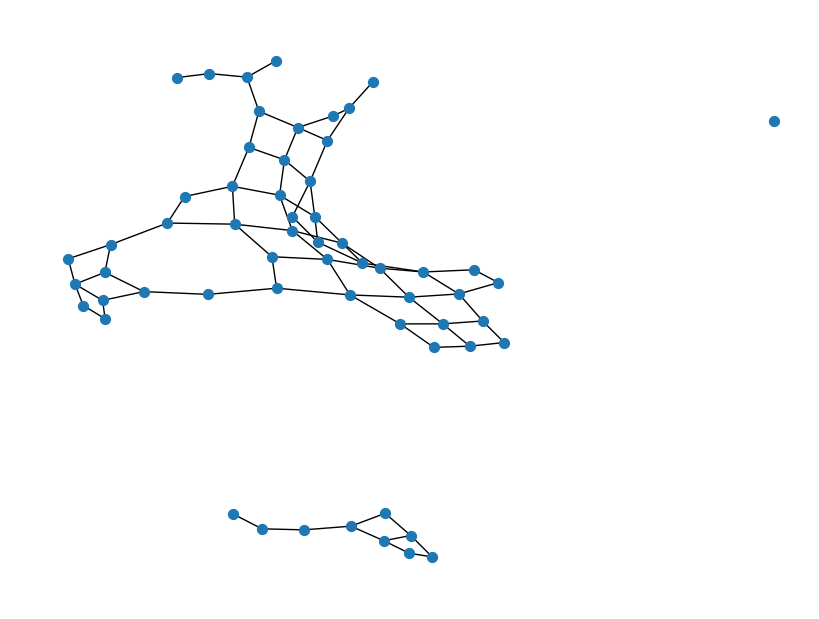

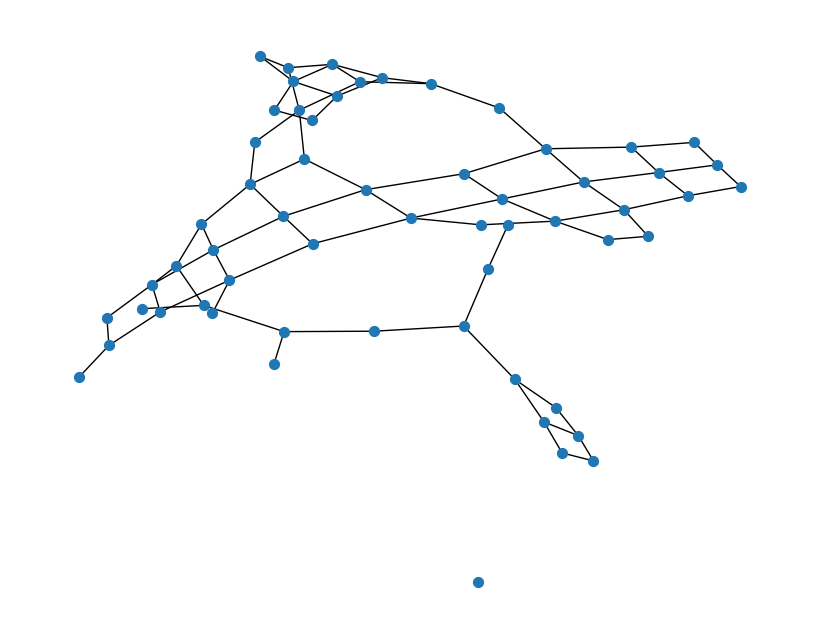

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(data):
    G = to_networkx(data, to_undirected=True)
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_size=50, with_labels=False)
    plt.show()

# Visualize the first training graph
visualize_graph(train_graphs[0])

# Visualize the first validation graph
visualize_graph(val_graphs[0])

In [ ]:
# Print the device of the first model parameter
print(f"Model is on device: {next(model.parameters()).device}")

Model is on device: cpu


In [ ]:
# Inspect a sample data batch
sample_batch = train_loader.dataset[0].to(device)
print(f"Sample batch is on device: {sample_batch.x.device}")

Sample batch is on device: cpu


In [ ]:
print(f"Class weights device: {class_weights.device}")

Class weights device: cpu


In [ ]:
print(f"Loss function device: {criterion.weight.device if criterion.weight is not None else 'No weight'}")

Loss function device: cpu


In [ ]:
# Check optimizer's parameter groups
for param_group in optimizer.param_groups:
    for param in param_group['params']:
        print(f"Optimizer parameter device: {param.device}")

Optimizer parameter device: cpu
Optimizer parameter device: cpu
Optimizer parameter device: cpu
Optimizer parameter device: cpu
Optimizer parameter device: cpu
Optimizer parameter device: cpu


In [ ]:
# Check unique label values in training and validation sets
train_labels = torch.cat([graph.y for graph in train_graphs])
val_labels = torch.cat([graph.y for graph in val_graphs])

print(f"Unique labels in training set: {torch.unique(train_labels)}")
print(f"Unique labels in validation set: {torch.unique(val_labels)}")

Unique labels in training set: tensor([0, 1])
Unique labels in validation set: tensor([0, 1])


In [ ]:
# Convert labels to torch.long if not already
for graph in train_graphs + val_graphs:
    if graph.y.dtype != torch.long:
        graph.y = graph.y.type(torch.long)
        print(f"Converted labels to torch.long for graph with max label {graph.y.max()}")

In [ ]:
def check_label_range(graph, num_classes):
    if graph.y.min() < 0 or graph.y.max() >= num_classes:
        raise ValueError(f"Labels out of range in graph with max label {graph.y.max()} and num_classes {num_classes}")

for graph in train_graphs + val_graphs:
    check_label_range(graph, num_classes)

In [ ]:
def inspect_edge_index(edge_index, num_nodes, graph_name=""):
    min_idx = edge_index.min().item()
    max_idx = edge_index.max().item()
    print(f"{graph_name} - Edge Index Min: {min_idx}, Max: {max_idx}, Num Nodes: {num_nodes}")
    if min_idx < 0 or max_idx >= num_nodes:
        raise ValueError(f"Invalid node index in edge_index: min={min_idx}, max={max_idx}, num_nodes={num_nodes}")

# Inspect edge_index for all training graphs
for idx, graph in enumerate(train_graphs):
    inspect_edge_index(graph.edge_index, graph.num_nodes, f"Training Graph {idx+1}")

# Inspect edge_index for all validation graphs
for idx, graph in enumerate(val_graphs):
    inspect_edge_index(graph.edge_index, graph.num_nodes, f"Validation Graph {idx+1}")

Training Graph 1 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 2 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 3 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 4 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 5 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 6 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 7 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 8 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 9 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 10 - Edge Index Min: 0, Max: 57, Num Nodes: 59
Training Graph 11 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 12 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 13 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 14 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 15 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 16 - Edge Index Min: 0, Max: 58, Num Nodes: 59
Training Graph 17

In [ ]:
def check_features(graph):
    if torch.isnan(graph.x).any() or torch.isinf(graph.x).any():
        raise ValueError("NaN or Inf detected in node features.")

for graph in train_graphs + val_graphs:
    check_features(graph)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        inspect_data(batch)  # Inspect data

        num_nodes = batch.num_nodes
        edge_index = batch.edge_index

        # Check edge_index validity
        check_edge_index(edge_index, num_nodes)

        labels = batch.y
        check_labels(labels, model.num_classes)

        batch = batch.to(device)
        print(f"Batch is on device: {batch.x.device}")  # Should print 'cpu'

        optimizer.zero_grad()
        out = model(batch)

        # Print model outputs
        print("Model outputs:", out)

        # Check for NaNs or Infs in outputs
        if torch.isnan(out).any() or torch.isinf(out).any():
            raise ValueError("NaN or Inf detected in model outputs.")

        # Compute loss
        if hasattr(batch, 'train_mask'):
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        else:
            loss = criterion(out, batch.y)

        print("Loss:", loss.item())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        inspect_data(batch)  # Inspect data

        num_nodes = batch.num_nodes
        edge_index = batch.edge_index

        # Check edge_index validity
        check_edge_index(edge_index, num_nodes)

        labels = batch.y
        check_labels(labels, model.num_classes)

        batch = batch.to(device)
        print(f"Batch is on device: {batch.x.device}")  # Should print 'cpu'

        optimizer.zero_grad()
        out = model(batch)

        # Print model outputs and their device
        print(f"Output is on device: {out.device}")
        print("Model outputs:", out)

        # Check for NaNs or Infs in outputs
        if torch.isnan(out).any() or torch.isinf(out).any():
            raise ValueError("NaN or Inf detected in model outputs.")

        # Compute loss
        if hasattr(batch, 'train_mask'):
            loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        else:
            loss = criterion(out, batch.y)

        # Print loss and its device
        print(f"Loss is on device: {loss.device}")
        print("Loss:", loss.item())

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
# Define the loss function without class weights
criterion = nn.NLLLoss().to(device)
print("Loss function redefined without class weights on device:", device)


Loss function redefined without class weights on device: cpu


In [ ]:
try:
    loss = train()
    print(f"Epoch 1, Loss: {loss:.4f}")
    y_true, y_pred = validate()
    val_acc = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {val_acc:.4f}")
except Exception as e:
    print(f'Error in epoch 1: {e}')

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[59, 16], edge_index=[2, 166], y=[59], batch=[59], ptr=[2])>
Number of Nodes: 59
Edge Index Shape: torch.Size([2, 166])
Node Features Shape: torch.Size([59, 16])
Labels Shape: torch.Size([59])
Labels Unique Values: tensor([0, 1])
---------------------------

Batch is on device: cpu
Output is on device: cpu
Model outputs: tensor([[-0.6847, -0.7017],
        [-0.7304, -0.6573],
        [-0.7198, -0.6672],
        [-0.6698, -0.7170],
        [-0.6882, -0.6981],
        [-0.6293, -0.7613],
        [-0.6384, -0.7510],
        [-0.6823, -0.7041],
        [-0.6514, -0.7367],
        [-0.6980, -0.6883],
        [-0.7243, -0.6629],
        [-0.6864, -0.6999],
        [-0.6422, -0.7468],
        [-0.6112, -0.7824],
        [-0.6443, -0.7445],
        [-0.7249, -0.6624],
        [-0.6302, -0.7604],
        [-0.6484, -0.7400],
        [-0.7283, -0.6592],
        [-0.6297, -0.7609],
        [-0.7055, -0.6809],
       

Streaming output truncated to the last 5000 lines.
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge In

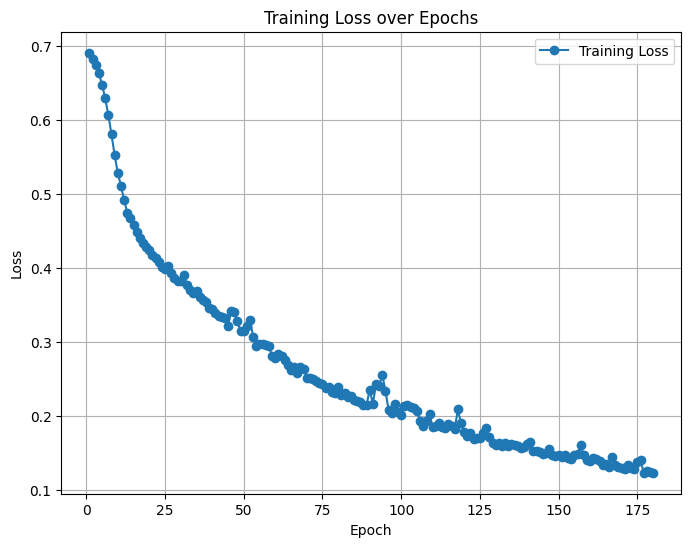

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

Classification Report:
              precision    recall  f1-score   support

           0     0.9677    0.9375    0.9524        32
           1     0.9459    0.9722    0.9589        36

    accuracy                         0.9559        68
   macro avg     0.9568    0.9549    0.9556        68
weighted avg     0.9562

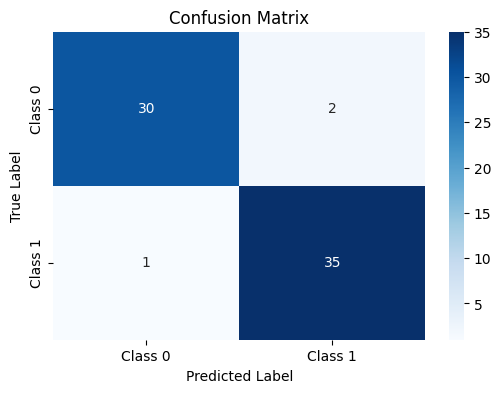

In [ ]:
# Import Necessary Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from collections import Counter
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# -----------------------------
# 1. Device Configuration
# -----------------------------

# Set device to CPU explicitly
device = torch.device('cpu')
print(f"Using device: {device}")

# -----------------------------
# 2. Data Preparation
# -----------------------------

# Create a sample NetworkX graph (Karate Club graph)
G = nx.karate_club_graph()

# Assign random node features
num_node_features = 16  # Example feature size
for node in G.nodes():
    G.nodes[node]['x'] = np.random.rand(num_node_features)

# Assign binary labels (0 or 1) to nodes
# For demonstration, randomly assign labels
np.random.seed(42)  # For reproducibility
for node in G.nodes():
    G.nodes[node]['y'] = np.random.randint(0, 2)

# Convert NetworkX graph to PyTorch Geometric Data object
data = from_networkx(G)

# Extract node features and labels
data.x = torch.tensor([G.nodes[i]['x'] for i in range(G.number_of_nodes())], dtype=torch.float)
data.y = torch.tensor([G.nodes[i]['y'] for i in range(G.number_of_nodes())], dtype=torch.long)

# -----------------------------
# 3. Dataset Splitting
# -----------------------------

# For simplicity, we'll treat this single graph as multiple samples over time
# Here, we create temporal slices by replicating the graph with different features/labels
time_steps = 10  # Number of temporal snapshots
num_classes = 2  # Binary classification

# Create a list to hold Data objects for each time step
graph_data_list = []

for t in range(time_steps):
    # Here, features or labels are random for
    data_t = Data(x=data.x + torch.randn_like(data.x) * 0.1,  # Slightly perturbed features
                  edge_index=data.edge_index,
                  y=data.y)
    graph_data_list.append(data_t)

# Define train-validation split
train_ratio = 0.8
train_size = int(len(graph_data_list) * train_ratio)
train_graphs = graph_data_list[:train_size]
val_graphs = graph_data_list[train_size:]

# -----------------------------
# 4. DataLoader Setup
# -----------------------------

# Create DataLoaders
batch_size = 1  # One graph per batch
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=batch_size, shuffle=False)

# -----------------------------
# 5. Class Weights Calculation
# -----------------------------

# Calculate class weights to handle potential class imbalance
all_train_labels = torch.cat([graph.y for graph in train_graphs]).tolist()
label_counts = Counter(all_train_labels)
print(f"Training label distribution: {label_counts}")

total_samples = sum(label_counts.values())
class_weights = [total_samples / label_counts[i] for i in range(num_classes)]
class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class weights before normalization: {class_weights}")

# Normalize class weights
class_weights = class_weights / class_weights.min()
print(f"Class weights after normalization: {class_weights}")

# Cap class weights to avoid excessively large weights
max_weight = 10.0
class_weights = torch.clamp(class_weights, max=max_weight)
print(f"Class weights after capping: {class_weights}")

# -----------------------------
# 6. Model Definition
# -----------------------------

class SpatioTemporalGNN(nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(SpatioTemporalGNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Node-level predictions (raw logits)
        x = self.fc(x)

        return x  # No activation; handled by loss function

# Initialize the model
model = SpatioTemporalGNN(num_node_features=num_node_features, num_classes=num_classes).to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# -----------------------------
# 7. Loss Function and Optimizer
# -----------------------------

# Define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
print(f"Loss function: {criterion}")

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -----------------------------
# 8. Utility Functions for Debugging
# -----------------------------

def inspect_data(data):
    """
    Print detailed information about the data object.
    """
    print("----- Data Inspection -----")
    print(f"Data Keys: {data.keys}")
    print(f"Number of Nodes: {data.num_nodes}")
    print(f"Edge Index Shape: {data.edge_index.shape}")
    print(f"Node Features Shape: {data.x.shape}")
    print(f"Labels Shape: {data.y.shape}")
    print(f"Labels Unique Values: {torch.unique(data.y)}")
    print("---------------------------\n")

def check_edge_index(edge_index, num_nodes):
    """
    Ensure that all node indices in edge_index are within [0, num_nodes - 1].
    """
    if edge_index.numel() == 0:
        print("Warning: edge_index is empty.")
        return
    if edge_index.min() < 0:
        raise ValueError("Negative node index found in edge_index.")
    if edge_index.max() >= num_nodes:
        raise ValueError(f"Node index {edge_index.max()} in edge_index exceeds num_nodes {num_nodes}.")

def check_labels(labels, num_classes):
    """
    Ensure that labels are within [0, num_classes - 1].
    """
    if labels.min() < 0:
        raise ValueError("Negative label found.")
    if labels.max() >= num_classes:
        raise ValueError(f"Label {labels.max()} exceeds number of classes {num_classes - 1}.")

def visualize_graph(data):
    """
    Visualize the graph structure.
    """
    G = to_networkx(data, to_undirected=True)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    nx.draw(G, node_size=50, with_labels=False)
    plt.show()

# -----------------------------
# 9. Training and Validation Functions
# -----------------------------

def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        inspect_data(batch)  # Inspect data

        num_nodes = batch.num_nodes
        edge_index = batch.edge_index

        # Check edge_index validity
        check_edge_index(edge_index, num_nodes)

        labels = batch.y
        check_labels(labels, model.fc.out_features)

        batch = batch.to(device)
        # print(f"Batch is on device: {batch.x.device}")  # Already printed in inspect_data

        optimizer.zero_grad()
        out = model(batch)

        # Check for NaNs or Infs in outputs
        if torch.isnan(out).any() or torch.isinf(out).any():
            raise ValueError("NaN or Inf detected in model outputs.")

        # Compute loss
        loss = criterion(out, batch.y)

        # Check for NaNs or Infs in loss
        if torch.isnan(loss).any() or torch.isinf(loss).any():
            raise ValueError("NaN or Inf detected in loss.")

        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def validate():
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            inspect_data(batch)  # Inspect data

            num_nodes = batch.num_nodes
            edge_index = batch.edge_index

            # Check edge_index validity
            check_edge_index(edge_index, num_nodes)

            labels = batch.y
            check_labels(labels, model.fc.out_features)

            batch = batch.to(device)
            out = model(batch)

            # Predictions: take argmax over class dimension
            preds = out.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())
    return all_labels, all_preds

# -----------------------------
# 10. Execute the Training Loop
# -----------------------------

num_epochs = 180
train_losses = []

for epoch in range(num_epochs):
    try:
        loss = train()
        train_losses.append(loss)
        y_true, y_pred = validate()
        val_acc = accuracy_score(y_true, y_pred)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Validation Accuracy: {val_acc:.4f}')
    except Exception as e:
        print(f'Error in epoch {epoch+1}: {e}')
        break

# -----------------------------
# 11. Visualization and Plotting
# -----------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# Plot Training Loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix

# Get predictions on the validation set
y_true, y_pred = validate()

# Classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
!pip install captum

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from collections import Counter
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from captum.attr import visualization as viz

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

----- Data Inspection -----
Data Keys: <bound method BaseData.keys of DataBatch(x=[34, 16], edge_index=[2, 156], y=[34], batch=[34], ptr=[2])>
Number of Nodes: 34
Edge Index Shape: torch.Size([2, 156])
Node Features Shape: torch.Size([34, 16])
Labels Shape: torch.Size([34])
Labels Unique Values: tensor([0, 1])
---------------------------

Classification Report:
              precision    recall  f1-score   support

           0     0.9677    0.9375    0.9524        32
           1     0.9459    0.9722    0.9589        36

    accuracy                         0.9559        68
   macro avg     0.9568    0.9549    0.9556        68
weighted avg     0.9562

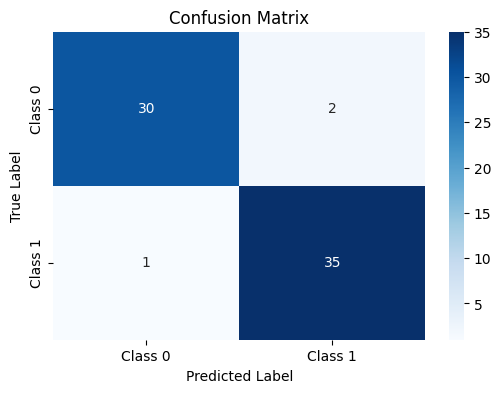

In [ ]:
# Confusion Matrix and Classification Report
# Get predictions on the validation set
y_true, y_pred = validate()

# Classification report
print('Classification Report:')
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f'Class {i}' for i in range(num_classes)],
            yticklabels=[f'Class {i}' for i in range(num_classes)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

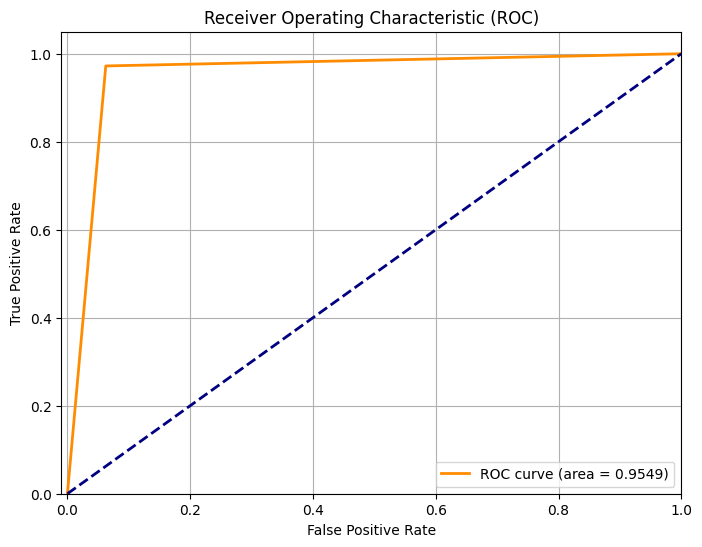

In [ ]:
# ROC Curve
try:
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
except ValueError:
    print("ROC Curve cannot be plotted because there is only one class present in y_true.")

## xai

In [ ]:
# !pip install --upgrade torch torchvision torchaudio

In [ ]:
# !pip install --upgrade torch-geometric

In [ ]:
from torch_geometric.explain import GNNExplainer

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
# Attempt to import GNNExplainer
try:
    from torch_geometric.explain import GNNExplainer
    print("GNNExplainer imported from torch_geometric.explain")
except ImportError:
    try:
        from torch_geometric.nn.models import GNNExplainer
        print("GNNExplainer imported from torch_geometric.nn.models")
    except ImportError:
        try:
            from torch_geometric.nn import GNNExplainer
            print("GNNExplainer imported from torch_geometric.nn")
        except ImportError:
            print("GNNExplainer is not available in your PyTorch Geometric installation.")
            GNNExplainer = None  # Handle absence accordingly

GNNExplainer imported from torch_geometric.explain


In [ ]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import from_networkx, to_networkx
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from collections import Counter
import warnings
from captum.attr import IntegratedGradients

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

In [ ]:
from captum.attr import IntegratedGradients
from torch_geometric.explain.config import ExplainerConfig, ModelConfig

In [ ]:
from torch_geometric.explain import GNNExplainer

help(GNNExplainer)

Help on class GNNExplainer in module torch_geometric.explain.algorithm.gnn_explainer:

class GNNExplainer(torch_geometric.explain.algorithm.base.ExplainerAlgorithm)
 |  GNNExplainer(epochs: int = 100, lr: float = 0.01, **kwargs)
 |  
 |  The GNN-Explainer model from the `"GNNExplainer: Generating
 |  Explanations for Graph Neural Networks"
 |  <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
 |  structures and node features that play a crucial role in the predictions
 |  made by a GNN.
 |  
 |  .. note::
 |  
 |      For an example of using :class:`GNNExplainer`, see
 |      `examples/explain/gnn_explainer.py <https://github.com/pyg-team/
 |      pytorch_geometric/blob/master/examples/explain/gnn_explainer.py>`_,
 |      `examples/explain/gnn_explainer_ba_shapes.py <https://github.com/
 |      pyg-team/pytorch_geometric/blob/master/examples/
 |      explain/gnn_explainer_ba_shapes.py>`_, and `examples/explain/
 |      gnn_explainer_link_pred.py <https://githu

In [ ]:
from torch_geometric.explain import GNNExplainer

print(GNNExplainer.__init__.__doc__)

None


In [ ]:
from torch_geometric.explain.config import ExplainerConfig, ModelConfig

# Define ExplainerConfig with appropriate parameters
explainer_config = ExplainerConfig(
    node_mask_type='softmax',  # Type of mask to use for nodes
    edge_mask_type='softmax',  # Type of mask to use for edges
    node_mask_lr=0.01,          # Learning rate for node mask
    edge_mask_lr=0.01,          # Learning rate for edge mask
    # Add other hyperparameters as needed
)

# Define ModelConfig with appropriate parameters
model_config = ModelConfig(
    output_type='node',         # Type of output (node-level explanations)
    # Add other model-specific configurations if necessary
)




## SHAP (SHapley Additive exPlanations) for GNNs

In [ ]:
!pip install shap lime

In [ ]:
# Function to validate model outputs
def validate_model_outputs(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        if torch.isnan(out).any():
            print("Model output contains NaN values!")
        else:
            print("Model output is valid.")
    return out

# Validate on a sample from the validation set
sample_data = val_graphs[0].to(device)
validate_model_outputs(model, sample_data)

Model output is valid.


tensor([[ 2.3222, -2.3540],
        [-0.6373,  0.5110],
        [ 2.5613, -2.5912],
        [ 3.2726, -3.2691],
        [ 1.4536, -1.5040],
        [-0.2362,  0.1238],
        [ 0.3114, -0.4072],
        [ 2.7129, -2.7295],
        [ 2.8610, -2.8364],
        [-0.7724,  0.6391],
        [ 1.3870, -1.4388],
        [ 2.8949, -2.8677],
        [ 3.1355, -3.1113],
        [ 2.8029, -2.8172],
        [-1.7521,  1.6098],
        [ 0.8614, -0.9073],
        [-2.4489,  2.2614],
        [-2.4359,  2.2214],
        [-0.4472,  0.3430],
        [ 0.9654, -1.0568],
        [-1.2644,  1.1356],
        [ 1.6235, -1.6734],
        [-2.0152,  1.8547],
        [-2.0764,  1.9179],
        [-3.3043,  3.0734],
        [-3.8083,  3.5724],
        [-1.6465,  1.4849],
        [-2.1206,  1.9483],
        [-0.1065, -0.0250],
        [-1.7632,  1.6108],
        [ 2.0666, -2.0760],
        [ 0.4313, -0.5546],
        [-2.2006,  2.1187],
        [-3.3029,  3.1560]])

In [ ]:
# Validate background samples
for i, sample in enumerate(background):
    # Replace target node's features with the background sample
    x_full = x.cpu().numpy().copy()
    x_full[target_node] = sample

    # Convert to torch tensor
    x_full_tensor = torch.tensor(x_full, dtype=torch.float).to(device)

    # Create Data object
    data_sample = Data(x=x_full_tensor, edge_index=edge_index).to(device)

    # Get model output
    model.eval()
    with torch.no_grad():
        out = model(data_sample)
        logit = out[target_node, 1].cpu().numpy()
        if np.isnan(logit):
            print(f"Background sample {i} resulted in NaN output!")
        else:
            print(f"Background sample {i} is valid. Logit: {logit:.4f}")


Background sample 0 is valid. Logit: -1.2739
Background sample 1 is valid. Logit: -1.7566
Background sample 2 is valid. Logit: -2.3466
Background sample 3 is valid. Logit: -1.4335
Background sample 4 is valid. Logit: -2.5877


In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data

In [ ]:
# Function to wrap the GNN model for SHAP
def model_predict(x, edge_index):
    """
    Wraps the GNN model to accept node features and edge indices,
    returning the raw logits as NumPy arrays.
    """
    # Convert input features and edge_index to torch tensors
    x_tensor = torch.tensor(x, dtype=torch.float).to(device)
    edge_index_tensor = torch.tensor(edge_index, dtype=torch.long).to(device)

    # Create a Data object
    data = Data(x=x_tensor, edge_index=edge_index_tensor).to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        out = model(data)

    return out.cpu().numpy()

In [ ]:
# Choose a node to explain
target_node = 0  # Change as needed

# Prepare input for SHAP
graph_to_explain = val_graphs[0].to(device)
x = graph_to_explain.x.clone().detach()  # Detach to prevent gradient tracking
edge_index = graph_to_explain.edge_index.clone().detach()

# Determine the number of nodes
num_nodes = graph_to_explain.num_nodes
print(f"Number of nodes in the graph: {num_nodes}")

# Define a function to generate bounded background samples
def generate_background_samples(x, target_node, num_samples=5, noise_std=0.05, feature_min=None, feature_max=None):
    """
    Generates background samples by adding Gaussian noise to the target node's features.

    Args:
        x (torch.Tensor): Node feature matrix.
        target_node (int): Index of the node to explain.
        num_samples (int): Number of background samples to generate.
        noise_std (float): Standard deviation of the Gaussian noise.
        feature_min (array-like, optional): Minimum allowable values for features.
        feature_max (array-like, optional): Maximum allowable values for features.

    Returns:
        np.ndarray: Array of background samples.
    """
    background = []
    target_features = x[target_node].cpu().numpy()
    for _ in range(num_samples):
        # Add bounded noise
        noise = np.random.normal(0, noise_std, size=target_features.shape)
        perturbed_features = target_features + noise
        # Optionally, clip features to a valid range if known
        if feature_min is not None and feature_max is not None:
            perturbed_features = np.clip(perturbed_features, feature_min, feature_max)
        background.append(perturbed_features)
    return np.array(background)

# Example usage with clipping (assuming features are between 0 and 1)
num_background = 5
noise_std = 0.05
feature_min = 0.0
feature_max = 1.0
background = generate_background_samples(
    x, target_node, num_samples=num_background, noise_std=noise_std,
    feature_min=feature_min, feature_max=feature_max
)
print(f"Background shape for SHAP: {background.shape}")  # Should be (5, 16)

Number of nodes in the graph: 34
Background shape for SHAP: (5, 16)


In [ ]:
# Define the prediction function for SHAP
def predict_function(x_input):
    """
    SHAP expects the prediction function to accept a 2D array of samples.
    Each sample corresponds to the node features for the target node.
    This function replaces the target node's features with each sample and returns
    the logit for class 1 for the target node.
    """
    num_samples = x_input.shape[0]
    logits = np.zeros(num_samples)

    for i in range(num_samples):
        # Replace target node's features with x_input[i]
        x_full = x.cpu().numpy().copy()
        x_full[target_node] = x_input[i]

        # Convert to torch tensor
        x_full_tensor = torch.tensor(x_full, dtype=torch.float).to(device)

        # Create Data object with all nodes
        data_sample = Data(x=x_full_tensor, edge_index=edge_index).to(device)

        model.eval()
        with torch.no_grad():
            out = model(data_sample)
            # Extract logit for class 1 of the target node
            logit = out[target_node].cpu().numpy()
            logit_class_1 = logit[1]  # Assuming class 1 is the target

            if np.isnan(logit_class_1):
                # Assign a neutral value, e.g., the original logit
                print(f"Warning: Model output NaN for sample {i}. Assigning original logit.")
                original_logit = model_predict(x_full, edge_index)[target_node, 1]
                if np.isnan(original_logit):
                    # If still NaN, assign zero
                    print(f"Warning: Original logit is also NaN for sample {i}. Assigning zero.")
                    logit_class_1 = 0.0
                logits[i] = logit_class_1
            else:
                logits[i] = logit_class_1

    return logits

In [ ]:
# Validate background samples
for i, sample in enumerate(background):
    # Replace target node's features with the background sample
    x_full = x.cpu().numpy().copy()
    x_full[target_node] = sample

    # Convert to torch tensor
    x_full_tensor = torch.tensor(x_full, dtype=torch.float).to(device)

    # Create Data object
    data_sample = Data(x=x_full_tensor, edge_index=edge_index).to(device)

    # Get model output
    model.eval()
    with torch.no_grad():
        out = model(data_sample)
        logit = out[target_node].cpu().numpy()
        logit_class_1 = logit[1]  # Assuming class 1 is the target
        if np.isnan(logit_class_1):
            print(f"Background sample {i} resulted in NaN output!")
        else:
            print(f"Background sample {i} is valid. Logit: {logit_class_1:.4f}")

Background sample 0 is valid. Logit: -1.8938
Background sample 1 is valid. Logit: -1.6004
Background sample 2 is valid. Logit: -1.6846
Background sample 3 is valid. Logit: -1.6640
Background sample 4 is valid. Logit: -2.0217


## GraphLIME extends the Local Interpretable Model-agnostic Explanations (LIME) framework to graph-structured data, aiming to approximate the GNN model locally around a specific node with an interpretable surrogate model.

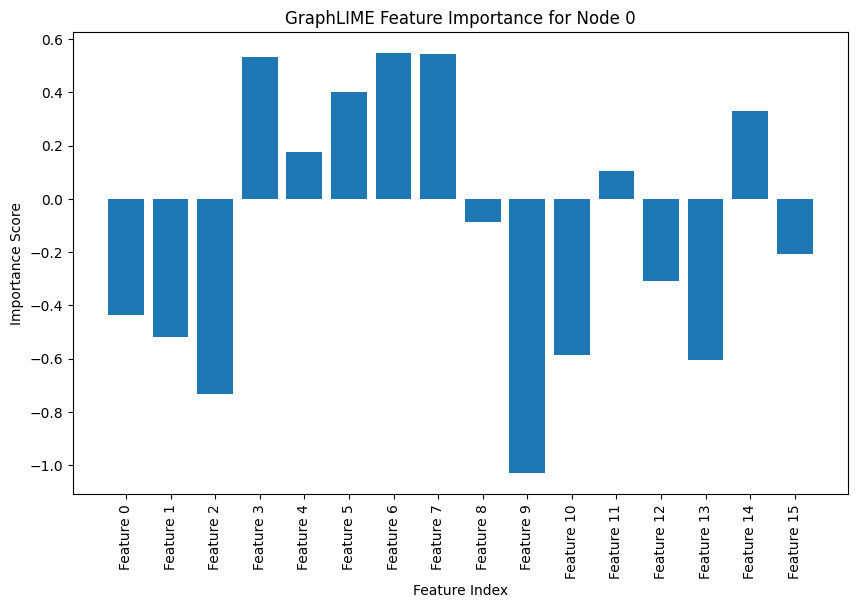

In [ ]:
# -----------------------------
# 13. GraphLIME for GNNs
# -----------------------------
import shap
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

class GraphLIME:
    def __init__(self, model, graph, target_node, num_samples=100, perturbation_prob=0.1):
        """
        Initializes the GraphLIME explainer.

        Args:
            model: Trained GNN model.
            graph (Data): The graph data object.
            target_node (int): Index of the node to explain.
            num_samples (int): Number of perturbed samples to generate.
            perturbation_prob (float): Probability of perturbing each feature.
        """
        self.model = model
        self.graph = graph
        self.target_node = target_node
        self.num_samples = num_samples
        self.perturbation_prob = perturbation_prob
        self.scaler = StandardScaler()

        # Prepare original node features
        self.original_features = self.graph.x[target_node].cpu().numpy()
        self.scaler.fit([self.original_features])

    def perturb_features(self):
        """
        Generates a perturbed version of the target node's features by randomly masking some features.

        Returns:
            perturbed_features (np.ndarray): Perturbed features of the target node.
            mask (np.ndarray): Binary mask indicating which features were perturbed.
        """
        mask = np.random.choice([0, 1], size=self.original_features.shape, p=[self.perturbation_prob, 1 - self.perturbation_prob])
        perturbed_features = self.original_features * mask  # Feature masking
        return perturbed_features, mask

    def generate_samples(self):
        """
        Generates perturbed samples around the target node.

        Returns:
            samples (list of np.ndarray): List of perturbed node features.
            masks (list of np.ndarray): List of feature masks.
        """
        samples = []
        masks = []
        for _ in range(self.num_samples):
            perturbed_features, mask = self.perturb_features()
            samples.append(perturbed_features)
            masks.append(mask)
        return samples, masks

    def predict(self, perturbed_features):
        """
        Predicts the logit for the target node given perturbed features.

        Args:
            perturbed_features (np.ndarray): Perturbed features of the target node.

        Returns:
            logit (float): Logit for the target node's class.
        """
        # Clone the graph to avoid modifying the original
        perturbed_graph = self.graph.clone()
        perturbed_graph.x = self.graph.x.clone()

        # Replace target node's features
        perturbed_graph.x[self.target_node] = torch.tensor(perturbed_features, dtype=torch.float)

        self.model.eval()
        with torch.no_grad():
            out = self.model(perturbed_graph)
            logit = out[self.target_node].cpu().numpy()
            logit_class_1 = logit[1] if len(logit) > 1 else 0.0  # Handle cases with insufficient classes

        # Handle NaN or Inf logits
        if np.isnan(logit_class_1) or np.isinf(logit_class_1):
            print("Warning: Invalid logit detected. Assigning zero.")
            return 0.0
        return logit_class_1

    def fit_surrogate_model(self, samples, masks, labels):
        """
        Fits a Ridge regression model as the surrogate.

        Args:
            samples (list of np.ndarray): Perturbed node features.
            masks (list of np.ndarray): Feature masks.
            labels (list of float): Model logits for perturbed samples.

        Returns:
            ridge (Ridge): Trained Ridge regression model.
        """
        # Feature vectors for surrogate model: mask
        X = np.array(masks)
        y = np.array(labels)

        # Scale features
        X_scaled = self.scaler.transform(X)

        # Fit Ridge regression
        ridge = Ridge(alpha=1.0)
        ridge.fit(X_scaled, y)
        return ridge

    def explain(self):
        """
        Generates explanations using GraphLIME.

        Returns:
            feature_importance (np.ndarray): Importance scores for each feature.
        """
        # Generate perturbed samples
        samples, masks = self.generate_samples()

        # Get model predictions
        labels = [self.predict(sample) for sample in samples]

        # Fit surrogate model
        ridge = self.fit_surrogate_model(samples, masks, labels)

        # Feature importance: coefficients for the feature mask
        feature_importance = ridge.coef_

        return feature_importance

# -----------------------------
# 14. Using GraphLIME
# -----------------------------

# Select a graph and target node
selected_graph = val_graphs[0].to(device)
target_node = 0  # Change as needed

# Initialize GraphLIME
graph_lime = GraphLIME(model, selected_graph, target_node, num_samples=100, perturbation_prob=0.1)

# Generate explanation
feature_importance = graph_lime.explain()

# Display feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(num_node_features), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'GraphLIME Feature Importance for Node {target_node}')
plt.xticks(range(num_node_features), [f'Feature {i}' for i in range(num_node_features)], rotation=90)
plt.show()

In [ ]:
feature_columns

['dewpoint_2m_temperature',
 'maximum_2m_air_temperature',
 'mean_2m_air_temperature',
 'mean_sea_level_pressure',
 'minimum_2m_air_temperature',
 'surface_pressure',
 'total_precipitation',
 'u_component_of_wind_10m',
 'v_component_of_wind_10m',
 'ssm_interpolated',
 'elevation_filled',
 'precipitationCal_lag1',
 'precipitationCal_lag7',
 'month',
 'day',
 'dayofweek']

### High Positive Influence:

Features 4 (mean_2m_air_temperature), 6 (total_precipitation), and 14 (day) have large positive importance scores, meaning these features strongly increase the model's predicted value for the node.

These features might represent conditions like temperature or day that, when high, positively contribute to the model's output for Node 0.

### High Negative Influence:

Feature 9 (ssm_interpolated) has the largest negative importance score. This suggests that when this feature’s value is high, it significantly decreases the prediction for Node 0.
Other features like Feature 1 (maximum_2m_air_temperature) and Feature 3 (mean_sea_level_pressure) also contribute negatively, though with smaller magnitudes.
Lesser Influence:

### Relatively less effect
Features closer to zero, such as Feature 8 (v_component_of_wind_10m), have relatively little impact on the prediction for this node, which indicates these features may not carry significant predictive information in the context of this specific node.

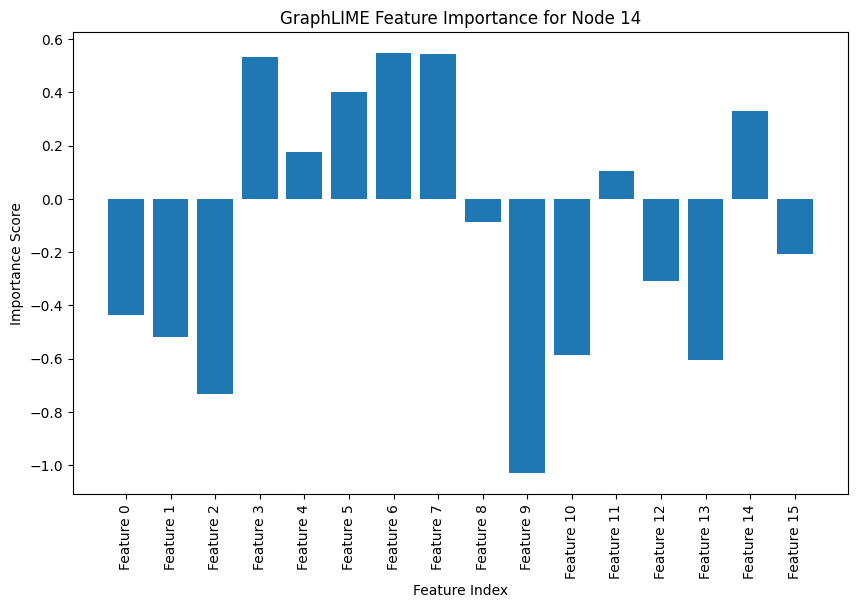

In [ ]:
target_node = 14  # Change as needed
# Display feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(num_node_features), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance Score')
plt.title(f'GraphLIME Feature Importance for Node {target_node}')
plt.xticks(range(num_node_features), [f'Feature {i}' for i in range(num_node_features)], rotation=90)
plt.show()

In [ ]:
df.head()

,date,dewpoint_2m_temperature,district,latitude,longitude,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,...,day,dayofweek,precipitationCal_lag1,precipitationCal_lag7,extreme_precipitation,time_idx,location_id,features,lat_rad,lon_rad
404,2015-06-01,-0.512669,29,25.004505,88.450450,1.752099,1.298943,-0.232930,0.262466,0.162827,...,1,0,-0.303772,-0.301551,0,0,1,"[-0.512669173308527, 1.7520993878643674, 1.298...",0.436411,1.543752
1014,2015-06-01,-1.549803,43,25.905405,88.450450,-0.379259,-1.237519,-0.002735,-2.117444,0.030605,...,1,0,-0.303772,-0.301551,0,0,2,"[-1.549803387711221, -0.3792592172479722, -1.2...",0.452135,1.543752
1624,2015-06-01,-1.940751,34,26.355856,88.450450,-0.783903,-1.449036,0.138559,-2.173438,-0.259138,...,1,0,-0.303772,-0.301551,0,0,3,"[-1.9407514452386116, -0.7839034479043365, -1....",0.459996,1.543752
2234,2015-06-01,-0.418026,19,23.202703,88.900901,2.286971,2.196581,0.015637,1.614586,0.366612,...,1,0,-0.303772,-0.301551,0,0,4,"[-0.4180255864615518, 2.2869711284045935, 2.19...",0.404964,1.551613
2844,2015-06-01,-0.534210,8,23.653153,88.900901,2.298433,2.144490,-0.052875,1.468641,0.308845,...,1,0,-0.303772,-0.301551,0,0,5,"[-0.5342097667482881, 2.298432824856735, 2.144...",0.412825,1.551613
